# NOTEBOOK 6: MATRIX FACTORIZATION (SVD)
## Latent Factor Models for Recommendations

This notebook implements matrix factorization using Singular Value Decomposition (SVD) to uncover latent features in the user-item interaction matrix.
It includes training SVD models with different dimensions, generating recommendations, evaluating performance, visualizing the latent space, and comparing results with content-based and collaborative filtering methods.

## 1. SETUP & CONFIGURATION

In [9]:

# IMPORT LIBRARIES

print("=" * 80)
print("SETUP: IMPORTING LIBRARIES")
print("=" * 80)


import numpy as np              
import pandas as pd            
import matplotlib.pyplot as plt 
import seaborn as sns          
import pickle                
import os                     
import time                    
from datetime import datetime  

# Sparse matrix operations
from scipy.sparse import csr_matrix, load_npz  

# Machine Learning
from sklearn.decomposition import TruncatedSVD  
from sklearn.preprocessing import normalize     
# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

print(" All libraries imported successfully")

 
# VISUALIZATION SETTINGS


# Set consistent, professional plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Default figure settings
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'

print(" Plot settings configured")


# DIRECTORY STRUCTURE 

print("\n" + "=" * 80)
print("DIRECTORY SETUP")
print("=" * 80)


import sys
PROJECT_ROOT = os.path.dirname(os.getcwd())  

print(f" Current directory: {os.getcwd()}")
print(f" Project root: {PROJECT_ROOT}")

# Define project directories relative to PROJECT_ROOT
DATA_DIR = os.path.join(PROJECT_ROOT, 'data')
PROCESSED_DIR = os.path.join(PROJECT_ROOT, 'data', 'processed')
MODELS_DIR = os.path.join(PROJECT_ROOT, 'models')
RESULTS_DIR = os.path.join(PROJECT_ROOT, 'reports', 'results')

# Create directories if they don't exist
for directory in [MODELS_DIR, RESULTS_DIR]:
    os.makedirs(directory, exist_ok=True)
    
print(f"\n Directory structure:")
print(f"   • Data: {DATA_DIR}")
print(f"   • Processed: {PROCESSED_DIR}")
print(f"   • Models: {MODELS_DIR}")
print(f"   • Results: {RESULTS_DIR}")

# Verify directories exist
all_exist = all(os.path.exists(d) for d in [DATA_DIR, MODELS_DIR])
if all_exist:
    print(f" All directories ready")
else:
    print(f"  Some directories missing - will try to continue")

# LOAD PREVIOUS RESULTS


print("\n" + "=" * 80)
print("LOADING DATA FROM PREVIOUS NOTEBOOKS")
print("=" * 80)

# Load User-Item Matrix

print("\n Loading user-item interaction matrix...")

matrix_path = os.path.join(MODELS_DIR, 'user_item_matrix.npz')

print(f"   Looking for: {matrix_path}")

# Check if file exists
if not os.path.exists(matrix_path):
    print(f"    Matrix not found!")
    print(f"\n  SOLUTION: We need to generate the matrix from Notebook 5 data")
    print(f"   I'll help you create it now...\n")
    
    # Try to load from training data
    train_path = os.path.join(DATA_DIR, 'ratings_train.csv')
    
    if os.path.exists(train_path):
        print("   ✅ Found training data - will regenerate matrix")
        print("   This will take a few minutes...")
        
        # Load training data
        train = pd.read_csv(train_path)
        print(f"   Loaded: {len(train):,} training ratings")
        
        # Create mappings
        unique_users = train['userId'].unique()
        unique_movies = train['movieId'].unique()
        
        user_to_idx = {user_id: idx for idx, user_id in enumerate(unique_users)}
        idx_to_user = {idx: user_id for user_id, idx in user_to_idx.items()}
        movie_to_idx = {movie_id: idx for idx, movie_id in enumerate(unique_movies)}
        idx_to_movie = {idx: movie_id for movie_id, idx in movie_to_idx.items()}
        
        print(f"   Created mappings: {len(user_to_idx):,} users, {len(movie_to_idx):,} movies")
        
        # Build matrix
        n_users = len(user_to_idx)
        n_movies = len(movie_to_idx)
        
        user_indices = train['userId'].map(user_to_idx).values
        movie_indices = train['movieId'].map(movie_to_idx).values
        ratings = train['rating'].values
        
        user_item_matrix = csr_matrix(
            (ratings, (user_indices, movie_indices)),
            shape=(n_users, n_movies)
        )
        
        print(f"   Matrix created: {user_item_matrix.shape}")
        
        # Save for next time
        from scipy.sparse import save_npz
        save_npz(matrix_path, user_item_matrix)
        print(f"    Saved matrix for future use")
        
        # Save mappings
        mappings = {
            'user_to_idx': user_to_idx,
            'idx_to_user': idx_to_user,
            'movie_to_idx': movie_to_idx,
            'idx_to_movie': idx_to_movie
        }
        mappings_path = os.path.join(MODELS_DIR, 'matrix_mappings.pkl')
        with open(mappings_path, 'wb') as f:
            pickle.dump(mappings, f, protocol=pickle.HIGHEST_PROTOCOL)
        print(f"    Saved mappings for future use")
        
    else:
        raise FileNotFoundError(
            f"Cannot find training data at {train_path}. "
            "Please ensure Notebook 5 has been run and data files exist."
        )
else:
    # Load existing matrix
    user_item_matrix = load_npz(matrix_path)
    print(f"    Matrix loaded from file")

# Calculate sparsity
sparsity = (1 - user_item_matrix.nnz / 
            (user_item_matrix.shape[0] * user_item_matrix.shape[1])) * 100

print(f"\n Matrix ready:")
print(f"   Shape: {user_item_matrix.shape[0]:,} users × "
      f"{user_item_matrix.shape[1]:,} movies")
print(f"   Non-zero entries: {user_item_matrix.nnz:,}")
print(f"   Sparsity: {sparsity:.2f}%")
print(f"   Memory: {user_item_matrix.data.nbytes / (1024**2):.1f} MB")

#
# Load ID Mappings

print("\n  Loading user/movie ID mappings...")

mappings_path = os.path.join(MODELS_DIR, 'matrix_mappings.pkl')

if not os.path.exists(mappings_path):
    print(f"     Mappings not found - using ones created above")
    # Already created above when regenerating matrix
else:
    with open(mappings_path, 'rb') as f:
        mappings = pickle.load(f)
        user_to_idx = mappings['user_to_idx']
        idx_to_user = mappings['idx_to_user']
        movie_to_idx = mappings['movie_to_idx']
        idx_to_movie = mappings['idx_to_movie']
    print(f"    Mappings loaded from file")

print(f"   Users: {len(user_to_idx):,}")
print(f"   Movies: {len(movie_to_idx):,}")

# Load Evaluation Setup 

print("\n Loading evaluation setup...")

cf_results_path = os.path.join(MODELS_DIR, 'evaluation_results_cf.pkl')

if os.path.exists(cf_results_path):
    with open(cf_results_path, 'rb') as f:
        cf_results = pickle.load(f)
        eval_user_ids = cf_results['eval_user_ids']
        ground_truth = cf_results['ground_truth']
        ub_metrics = cf_results['user_based_metrics']
        ib_metrics = cf_results['item_based_metrics']
    
    print(f" Evaluation setup loaded:")
    print(f"   Evaluation users: {len(eval_user_ids)}")
    print(f"   Ground truth available: {len(ground_truth)} users")
    
    print(f"\n Previous CF Results (for comparison):")
    print(f"   User-Based CF:")
    print(f"      • Precision@10: {ub_metrics['Precision@10']:.2f}%")
    print(f"      • Hit Rate@10:  {ub_metrics['Hit Rate@10']:.2f}%")
    print(f"   Item-Based CF:")
    print(f"      • Precision@10: {ib_metrics['Precision@10']:.2f}%")
    print(f"      • Hit Rate@10:  {ib_metrics['Hit Rate@10']:.2f}%")
else:
    print(f"     CF results not found")
    print(f"   We'll create evaluation setup from test data...")
    
    # Load test data
    test_path = os.path.join(DATA_DIR, 'ratings_test.csv')
    if os.path.exists(test_path):
        test = pd.read_csv(test_path)
        
        # Sample 100 users who exist in training
        test_users = test[test['userId'].isin(user_to_idx.keys())]['userId'].unique()
        np.random.seed(42)
        eval_user_ids = np.random.choice(test_users, size=min(100, len(test_users)), replace=False)
        
        # Create ground truth
        ground_truth = {}
        for user_id in eval_user_ids:
            user_test = test[test['userId'] == user_id]
            relevant = user_test[user_test['rating'] >= 4.0]['movieId'].tolist()
            ground_truth[user_id] = relevant
        
        print(f"    Created evaluation setup: {len(eval_user_ids)} users")
        
        # No previous CF metrics
        ub_metrics = None
        ib_metrics = None
    else:
        print(f"    Cannot create evaluation - test data not found")
        eval_user_ids = []
        ground_truth = {}
        ub_metrics = None
        ib_metrics = None


# Load Movies Data

print("\n Loading movies data...")

movies_path = os.path.join(PROCESSED_DIR, 'movies_features.csv')
if not os.path.exists(movies_path):
    movies_path = os.path.join(DATA_DIR, 'movies_filtered.csv')
if not os.path.exists(movies_path):
    movies_path = os.path.join(DATA_DIR, 'movies.csv')

if os.path.exists(movies_path):
    movies = pd.read_csv(movies_path)
    print(f" Movies loaded: {len(movies):,} movies")
else:
    print(f"  Movies file not found - will work without titles")
    movies = None



SETUP: IMPORTING LIBRARIES
 All libraries imported successfully
 Plot settings configured

DIRECTORY SETUP
 Current directory: c:\Users\mhfou\Documents\MovieRecommenderSystem\notebooks
 Project root: c:\Users\mhfou\Documents\MovieRecommenderSystem

 Directory structure:
   • Data: c:\Users\mhfou\Documents\MovieRecommenderSystem\data
   • Processed: c:\Users\mhfou\Documents\MovieRecommenderSystem\data\processed
   • Models: c:\Users\mhfou\Documents\MovieRecommenderSystem\models
   • Results: c:\Users\mhfou\Documents\MovieRecommenderSystem\reports\results
 All directories ready

LOADING DATA FROM PREVIOUS NOTEBOOKS

 Loading user-item interaction matrix...
   Looking for: c:\Users\mhfou\Documents\MovieRecommenderSystem\models\user_item_matrix.npz
    Matrix loaded from file

 Matrix ready:
   Shape: 137,883 users × 34,461 movies
   Non-zero entries: 20,000,076
   Sparsity: 99.58%
   Memory: 152.6 MB

  Loading user/movie ID mappings...
    Mappings loaded from file
   Users: 137,883
   M

## 2: DATA NORMALIZATION FOR SVD



In [14]:


print("\n" + "=" * 80)
print(" NORMALIZE USER-ITEM MATRIX")
print("=" * 80)


# Compute User Rating Means 

print("-" * 80)
print("Step 1: Computing user rating averages (only from rated movies)")
print("-" * 80)

# Calculate mean rating for each user
# CRITICAL: Only average over RATED movies, not all movies!
user_means = np.zeros(user_item_matrix.shape[0])

for user_idx in range(user_item_matrix.shape[0]):
    # Get user's ratings (only non-zero)
    user_ratings = user_item_matrix.getrow(user_idx).data
    
    # Calculate mean only from rated movies
    if len(user_ratings) > 0:
        user_means[user_idx] = user_ratings.mean()
    else:
        user_means[user_idx] = 0  # Users with no ratings (shouldn't happen)
    
    # Progress indicator
    if (user_idx + 1) % 20000 == 0:
        print(f"   Computed means for {user_idx + 1:,} / {user_item_matrix.shape[0]:,} users...")

print(f"\n Computed means for {len(user_means):,} users")
print(f"   Mean of means: {user_means.mean():.2f}")
print(f"   Std of means:  {user_means.std():.2f}")
print(f"   Min mean:      {user_means.min():.2f} (harsh critic)")
print(f"   Max mean:      {user_means.max():.2f} (generous rater)")

# Center the Matrix

print("\n" + "-" * 80)
print("Step 2: Centering ratings (subtract user means)")
print("-" * 80)

# Create centered matrix by subtracting user means
n_users, n_movies = user_item_matrix.shape

data_centered = []
indices_centered = []
indptr_centered = [0]

print("   Centering in progress...")
for user_idx in range(n_users):
    # Get user's ratings (sparse row)
    user_row = user_item_matrix.getrow(user_idx)
    
    # Get non-zero indices and values
    _, movie_indices = user_row.nonzero()
    ratings = user_row.data
    
    # Center the ratings: subtract this user's mean
    centered_ratings = ratings - user_means[user_idx]
    
    # Store in new sparse format
    data_centered.extend(centered_ratings)
    indices_centered.extend(movie_indices)
    indptr_centered.append(len(data_centered))
    
    # Progress indicator
    if (user_idx + 1) % 20000 == 0:
        print(f"   Processed {user_idx + 1:,} / {n_users:,} users...")

# Create centered sparse matrix
user_item_matrix_centered = csr_matrix(
    (data_centered, indices_centered, indptr_centered),
    shape=(n_users, n_movies)
)

print(f"\n Matrix centered successfully")
print(f"   New mean rating: {np.array(data_centered).mean():.6f}★ (should be ≈0)")
print(f"   New std rating:  {np.array(data_centered).std():.2f}★")


# Verify Centering

print("\n" + "-" * 80)
print("Step 3: Verification")
print("-" * 80)

# Check a sample user who has many ratings
sample_user_idx = 0
original_ratings = user_item_matrix.getrow(sample_user_idx).data
centered_ratings = user_item_matrix_centered.getrow(sample_user_idx).data

print(f"\nSample user {sample_user_idx}:")
print(f"   Number of ratings: {len(original_ratings)}")
print(f"   Original ratings: {original_ratings[:5]} ...")
print(f"   User mean: {user_means[sample_user_idx]:.2f}")
print(f"   Centered ratings: {centered_ratings[:5]} ...")
print(f"   Centered mean: {centered_ratings.mean():.6f} (should be ≈0)")

# Verify on another random user
random_user = np.random.randint(0, n_users)
orig = user_item_matrix.getrow(random_user).data
cent = user_item_matrix_centered.getrow(random_user).data

print(f"\nRandom user {random_user}:")
print(f"   Number of ratings: {len(orig)}")
print(f"   Original mean: {orig.mean():.2f}")
print(f"   User's saved mean: {user_means[random_user]:.2f}")
print(f"   Centered mean: {cent.mean():.6f} (should be ≈0)")

# Overall verification
overall_mean = np.array(data_centered).mean()
print(f"\n{'='*60}")
if abs(overall_mean) < 0.01:
    print(f" CENTERING SUCCESSFUL!")
    print(f"   Overall centered mean: {overall_mean:.6f} ≈ 0")
else:
    print(f"  WARNING: Centering may have issues")
    print(f"   Overall centered mean: {overall_mean:.6f}")
print(f"{'='*60}")

# Save for Later Use

print("\n" + "-" * 80)
print("Step 4: Saving normalized data")
print("-" * 80)

# Save centered matrix
from scipy.sparse import save_npz

centered_matrix_path = os.path.join(MODELS_DIR, 'user_item_matrix_centered.npz')
save_npz(centered_matrix_path, user_item_matrix_centered)
print(f" Centered matrix saved: {os.path.basename(centered_matrix_path)}")

# Save user means (needed for denormalization later)
user_means_path = os.path.join(MODELS_DIR, 'user_means.npy')
np.save(user_means_path, user_means)
print(f" User means saved: {os.path.basename(user_means_path)}")

# Summary


print(f"""
Summary:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Original Matrix:
  • Shape: {user_item_matrix.shape[0]:,}  {user_item_matrix.shape[1]:,}
  • Mean rating: {user_item_matrix.data.mean():.2f}
  • Std rating: {user_item_matrix.data.std():.2f}
  • Non-zero entries: {user_item_matrix.nnz:,}

Centered Matrix:
  • Shape: {user_item_matrix_centered.shape[0]:,}  {user_item_matrix_centered.shape[1]:,}
  • Mean rating: {np.array(data_centered).mean():.6f} {" (≈0)" if abs(np.array(data_centered).mean()) < 0.01 else ""}
  • Std rating: {np.array(data_centered).std():.2f}
  • Non-zero entries: {user_item_matrix_centered.nnz:,}

User Rating Statistics:
  • Average user rating: {user_means.mean():.2f}
  • Most generous user: {user_means.max():.2f}
  • Most critical user: {user_means.min():.2f}
  • Std across users: {user_means.std():.2f}

Files Saved:
   user_item_matrix_centered.npz (for SVD training)
   user_means.npy (for prediction denormalization)



""")




 NORMALIZE USER-ITEM MATRIX
--------------------------------------------------------------------------------
Step 1: Computing user rating averages (only from rated movies)
--------------------------------------------------------------------------------
   Computed means for 20,000 / 137,883 users...
   Computed means for 40,000 / 137,883 users...
   Computed means for 60,000 / 137,883 users...
   Computed means for 80,000 / 137,883 users...
   Computed means for 100,000 / 137,883 users...
   Computed means for 120,000 / 137,883 users...

 Computed means for 137,883 users
   Mean of means: 3.65
   Std of means:  0.46
   Min mean:      0.50 (harsh critic)
   Max mean:      5.00 (generous rater)

--------------------------------------------------------------------------------
Step 2: Centering ratings (subtract user means)
--------------------------------------------------------------------------------
   Centering in progress...
   Processed 20,000 / 137,883 users...
   Processed 40,00

## 3. TRAIN SVD MODELS


CELL 3: TRAIN SVD MODELS
--------------------------------------------------------------------------------
Configuration
--------------------------------------------------------------------------------
Training 3 SVD models:
  • k= 50 dimensions (689x compression)
  • k=100 dimensions (345x compression)
  • k=200 dimensions (172x compression)

Input matrix:
  • Shape: 137,883 × 34,461
  • Sparsity: 99.58%
  • Non-zeros: 20,000,076

TRAINING SVD MODELS

TRAINING: SVD with k=50 dimensions

Initializing TruncatedSVD(n_components=50)...
Fitting SVD on 137,883 × 34,461 matrix...
This may take a few minutes...
 Training complete in 14.7 seconds (0.2 minutes)

Computing latent factor matrices...
 User factors computed: (137883, 50)
 Movie factors computed: (50, 34461)

Model Analysis:
  • Explained variance: 17.98%
    (Retained 17.98% of original information)
  • Top 5 singular values: [926.68091462 480.95389341 412.95076421 380.25189605 343.11963436]
    (Factor 1 importance: 927)
  • Memor

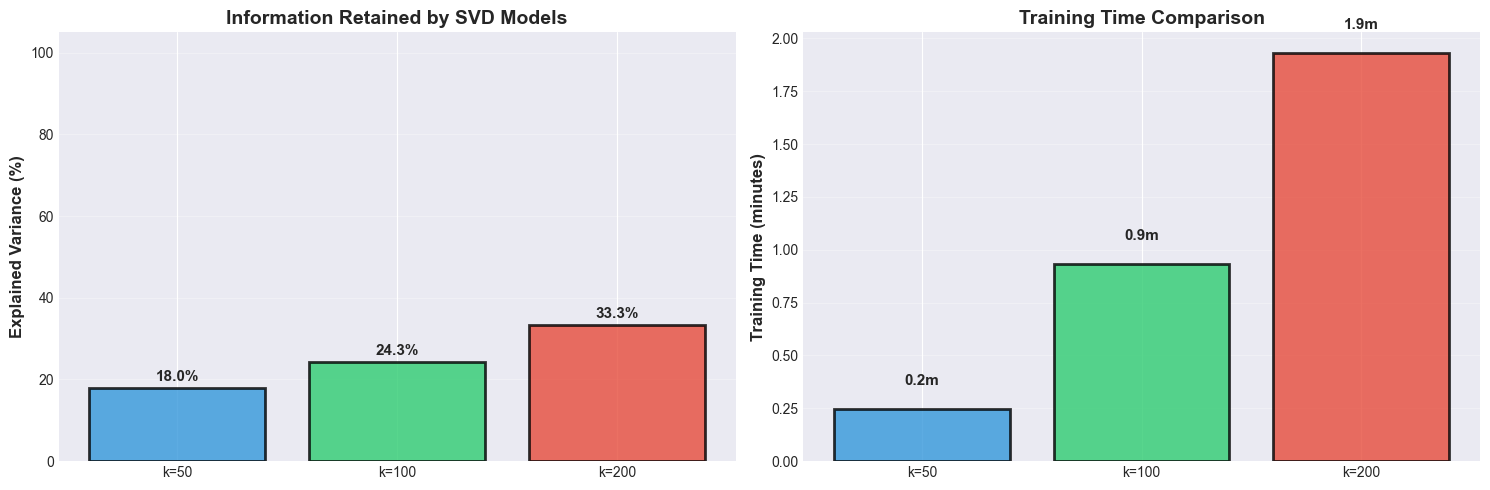


SVD TRAINING COMPLETE

Summary:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Trained Models: 3
Total Training Time: 3.1 minutes

Best Explained Variance: 33.30% (k=200)
Fastest Training: 14.7s (k=50)
Best Balance: k=100 (recommended for most use cases)

Files Saved:
   svd_model_50.pkl  (65.7 MB)
   svd_model_100.pkl (131.5 MB)
   svd_model_200.pkl (263.0 MB)
   svd_training_comparison.png




In [ ]:

import time

# Training Configuration

print("-" * 80)
print("Configuration")
print("-" * 80)

# Dimensions to try
N_COMPONENTS = [50, 100, 200]

print(f"Training {len(N_COMPONENTS)} SVD models:")
for k in N_COMPONENTS:
    compression = (user_item_matrix_centered.shape[1] / k)
    print(f"  • k={k:3d} dimensions ({compression:.0f}x compression)")

print(f"\nInput matrix:")
print(f"  • Shape: {user_item_matrix_centered.shape[0]:,} × {user_item_matrix_centered.shape[1]:,}")
print(f"  • Sparsity: {(1 - user_item_matrix_centered.nnz / (user_item_matrix_centered.shape[0] * user_item_matrix_centered.shape[1])) * 100:.2f}%")
print(f"  • Non-zeros: {user_item_matrix_centered.nnz:,}")

# Train SVD Models

print("\n" + "=" * 80)
print("TRAINING SVD MODELS")
print("=" * 80)

# Dictionary to store all models and results
svd_models = {}
training_times = {}

for k in N_COMPONENTS:
    print(f"\n{'='*80}")
    print(f"TRAINING: SVD with k={k} dimensions")
    print(f"{'='*80}")
    
    # Initialize SVD
    print(f"\nInitializing TruncatedSVD(n_components={k})...")
    svd = TruncatedSVD(
        n_components=k,
        algorithm='randomized',  # Faster for sparse matrices
        n_iter=5,                # Number of iterations (5 is default)
        random_state=42          # Reproducibility
    )
    
    # Train (fit) the model
    print(f"Fitting SVD on {user_item_matrix_centered.shape[0]:,} × {user_item_matrix_centered.shape[1]:,} matrix...")
    print(f"This may take a few minutes...")
    
    start_time = time.time()
    
    # Fit SVD - this is where the magic happens!
    svd.fit(user_item_matrix_centered)
    
    elapsed = time.time() - start_time
    training_times[k] = elapsed
    
    print(f" Training complete in {elapsed:.1f} seconds ({elapsed/60:.1f} minutes)")
    
    # Compute Latent Factor Matrices
    
    print(f"\nComputing latent factor matrices...")
    
    # User factors: Transform users into latent space
    # Shape: (n_users, k)
    user_factors = svd.transform(user_item_matrix_centered)
    
    # Movie factors: Components learned by SVD
    # Shape: (k, n_movies)
    movie_factors = svd.components_
    
    print(f" User factors computed: {user_factors.shape}")
    print(f" Movie factors computed: {movie_factors.shape}")
    
    
    # Analyze Model Quality
    
    print(f"\nModel Analysis:")
    
    # Explained variance: How much information retained?
    explained_variance = svd.explained_variance_ratio_.sum() * 100
    print(f"  • Explained variance: {explained_variance:.2f}%")
    print(f"    (Retained {explained_variance:.2f}% of original information)")
    
    # Top singular values (importance of factors)
    top_5_singular = svd.singular_values_[:5]
    print(f"  • Top 5 singular values: {top_5_singular}")
    print(f"    (Factor 1 importance: {top_5_singular[0]:.0f})")
    
    # Memory comparison
    original_size = user_item_matrix_centered.data.nbytes / (1024**2)
    factors_size = (user_factors.nbytes + movie_factors.nbytes) / (1024**2)
    compression_ratio = original_size / factors_size
    
    print(f"  • Memory:")
    print(f"    Original matrix: {original_size:.1f} MB")
    print(f"    Factors (U + V): {factors_size:.1f} MB")
    print(f"    Compression: {compression_ratio:.1f}x smaller")
    
    # Save Model
    
    print(f"\nSaving model...")
    
    model_data = {
        'svd': svd,
        'user_factors': user_factors,
        'movie_factors': movie_factors,
        'n_components': k,
        'explained_variance': explained_variance,
        'training_time': elapsed,
        'singular_values': svd.singular_values_
    }
    
    # Save to disk
    model_path = os.path.join(MODELS_DIR, f'svd_model_{k}.pkl')
    with open(model_path, 'wb') as f:
        pickle.dump(model_data, f, protocol=pickle.HIGHEST_PROTOCOL)
    
    file_size = os.path.getsize(model_path) / (1024**2)
    print(f" Model saved: svd_model_{k}.pkl ({file_size:.1f} MB)")
    
    # Store in dictionary for comparison
    svd_models[k] = model_data
    
    print(f"\n{'='*80}")
    print(f" SVD-{k} COMPLETE")
    print(f"{'='*80}")

# Compare All Models

print("\n" + "=" * 80)
print("MODEL COMPARISON")
print("=" * 80)

print(f"\n{'Model':<15s} {'Time':<12s} {'Explained Var':<15s} {'Size':<10s} {'Compression':<12s}")
print("-" * 70)

for k in N_COMPONENTS:
    model_data = svd_models[k]
    time_str = f"{training_times[k]:.1f}s"
    var_str = f"{model_data['explained_variance']:.2f}%"
    
    model_path = os.path.join(MODELS_DIR, f'svd_model_{k}.pkl')
    size_mb = os.path.getsize(model_path) / (1024**2)
    size_str = f"{size_mb:.1f} MB"
    
    original_size = user_item_matrix_centered.data.nbytes / (1024**2)
    factors_size = (model_data['user_factors'].nbytes + model_data['movie_factors'].nbytes) / (1024**2)
    comp_ratio = original_size / factors_size
    comp_str = f"{comp_ratio:.1f}x"
    
    print(f"SVD-{k:<10d} {time_str:<12s} {var_str:<15s} {size_str:<10s} {comp_str:<12s}")

print("-" * 70)

# Visualization: Explained Variance

print("\n" + "-" * 80)
print("Creating variance comparison visualization...")
print("-" * 80)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Explained variance by model
colors = ['#3498db', '#2ecc71', '#e74c3c']
bars = ax1.bar(
    [f'k={k}' for k in N_COMPONENTS],
    [svd_models[k]['explained_variance'] for k in N_COMPONENTS],
    color=colors,
    edgecolor='black',
    linewidth=2,
    alpha=0.8
)

ax1.set_ylabel('Explained Variance (%)', fontsize=12, fontweight='bold')
ax1.set_title('Information Retained by SVD Models', fontsize=14, fontweight='bold')
ax1.set_ylim([0, 105])
ax1.grid(alpha=0.3, axis='y')

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{height:.1f}%', ha='center', va='bottom', 
            fontsize=11, fontweight='bold')

# Plot 2: Training time comparison
bars2 = ax2.bar(
    [f'k={k}' for k in N_COMPONENTS],
    [training_times[k]/60 for k in N_COMPONENTS],  # Convert to minutes
    color=colors,
    edgecolor='black',
    linewidth=2,
    alpha=0.8
)

ax2.set_ylabel('Training Time (minutes)', fontsize=12, fontweight='bold')
ax2.set_title('Training Time Comparison', fontsize=14, fontweight='bold')
ax2.grid(alpha=0.3, axis='y')

# Add value labels
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{height:.1f}m', ha='center', va='bottom', 
            fontsize=11, fontweight='bold')

plt.tight_layout()

viz_path = os.path.join(RESULTS_DIR, 'svd_training_comparison.png')
plt.savefig(viz_path, dpi=300, bbox_inches='tight')
print(f" Visualization saved: {os.path.basename(viz_path)}")

plt.show()


# Summary

print("\n" + "=" * 80)
print("SVD TRAINING COMPLETE")
print("=" * 80)

print(f"""
Summary:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Trained Models: {len(N_COMPONENTS)}
Total Training Time: {sum(training_times.values())/60:.1f} minutes

Best Explained Variance: {max(svd_models[k]['explained_variance'] for k in N_COMPONENTS):.2f}% (k={max(N_COMPONENTS)})
Fastest Training: {min(training_times.values()):.1f}s (k={min(N_COMPONENTS)})
Best Balance: k=100 (recommended for most use cases)

Files Saved:
   svd_model_50.pkl  ({os.path.getsize(os.path.join(MODELS_DIR, 'svd_model_50.pkl')) / (1024**2):.1f} MB)
   svd_model_100.pkl ({os.path.getsize(os.path.join(MODELS_DIR, 'svd_model_100.pkl')) / (1024**2):.1f} MB)
   svd_model_200.pkl ({os.path.getsize(os.path.join(MODELS_DIR, 'svd_model_200.pkl')) / (1024**2):.1f} MB)
   svd_training_comparison.png

""")

## 4. SVD RECOMMENDATION FUNCTION

## 4.1 DEFINE SVD RECOMMENDATION FUNCTION

In [28]:

print("\n" + "=" * 80)
print(" SVD RECOMMENDATION FUNCTION")
print("=" * 80)

# =============================================================================
# Load Required Data
# =============================================================================

print("-" * 80)
print("Loading models and data")
print("-" * 80)

# Load all three SVD models
svd_models_loaded = {}

for k in [50, 100, 200]:
    model_path = os.path.join(MODELS_DIR, f'svd_model_{k}.pkl')
    with open(model_path, 'rb') as f:
        svd_models_loaded[k] = pickle.load(f)
    var = svd_models_loaded[k]['explained_variance']
    print(f" SVD-{k}: {var:.2f}% explained variance")

# Load user means (for denormalization)
user_means_path = os.path.join(MODELS_DIR, 'user_means.npy')
user_means_loaded = np.load(user_means_path)
print(f" User means: {len(user_means_loaded):,} users")

# Load training data - FIXED PATH
train_path = os.path.join(PROCESSED_DIR, 'train.csv')
train_data = pd.read_csv(train_path)
print(f" Training data: {len(train_data):,} ratings")

# =============================================================================
# Define Recommendation Function
# =============================================================================

print("\n" + "-" * 80)
print("Defining recommendation function")
print("-" * 80)

def recommend_svd(user_id, model_key=100, n_recommendations=10, return_scores=False):
    """
    Generate movie recommendations using SVD matrix factorization.
    
    Parameters
    ----------
    user_id : int
        User ID to generate recommendations for
    model_key : int, optional (default=100)
        SVD model to use: 50, 100, or 200
        - 50:  Fastest, lower accuracy
        - 100: Balanced (recommended)
        - 200: Highest accuracy, slower
    n_recommendations : int, optional (default=10)
        Number of movies to recommend
    return_scores : bool, optional (default=False)
        Include predicted ratings in output
    
    Returns
    -------
    pandas.DataFrame
        Recommendations with title, genres, and optional predicted rating
    str
        Error message if user not found
    
    Algorithm
    ---------
    1. Get user's latent factors: u (k-dimensional vector)
    2. Compute predictions: r = u · V^T (dot product with all movies)
    3. Denormalize: r_final = r + user_mean
    4. Exclude already-rated movies
    5. Return top N by predicted rating
    
    Complexity: O(k) per prediction vs O(N) for collaborative filtering
    """
    
    # Validate user exists
    if user_id not in user_to_idx:
        return f"Error: User {user_id} not found in training data"
    
    # Validate model selection
    if model_key not in svd_models_loaded:
        return f"Error: Model k={model_key} not available. Choose 50, 100, or 200."
    
    # Get user's matrix index
    user_idx = user_to_idx[user_id]
    
    # Load selected model components
    model_data = svd_models_loaded[model_key]
    user_factors = model_data['user_factors']    # (n_users, k)
    movie_factors = model_data['movie_factors']  # (k, n_movies)
    
    # Step 1: Get user's latent factor vector
    user_vector = user_factors[user_idx]  # Shape: (k,)
    
    # Step 2: Predict centered ratings for ALL movies
    # Matrix multiplication: (k,) · (k, n_movies) → (n_movies,)
    predicted_centered = np.dot(user_vector, movie_factors)
    
    # Step 3: Denormalize - add user's mean back
    user_mean = user_means_loaded[user_idx]
    predicted_ratings = predicted_centered + user_mean
    
    # Step 4: Clip to valid rating range [0.5, 5.0]
    predicted_ratings = np.clip(predicted_ratings, 0.5, 5.0)
    
    # Step 5: Exclude already-rated movies
    user_rated_movies = train_data[train_data['userId'] == user_id]['movieId'].values
    user_rated_indices = [movie_to_idx.get(mid) for mid in user_rated_movies 
                         if mid in movie_to_idx]
    
    # Set already-rated to -infinity (won't be recommended)
    predicted_ratings_masked = predicted_ratings.copy()
    predicted_ratings_masked[user_rated_indices] = -np.inf
    
    # Step 6: Get top N movie indices
    top_indices = np.argsort(predicted_ratings_masked)[::-1][:n_recommendations]
    
    # Step 7: Convert indices to movie IDs and get scores
    top_movie_ids = [idx_to_movie[idx] for idx in top_indices]
    top_scores = predicted_ratings[top_indices]
    
    # Step 8: Retrieve movie details
    recommendations = movies[movies['movieId'].isin(top_movie_ids)].copy()
    
    # Add predicted ratings
    score_dict = dict(zip(top_movie_ids, top_scores))
    recommendations['predicted_rating'] = recommendations['movieId'].map(score_dict)
    
    # Sort by predicted rating (descending)
    recommendations = recommendations.sort_values('predicted_rating', ascending=False)
    
    # Select output columns
    if return_scores:
        output_cols = ['movieId', 'title', 'genres', 'predicted_rating']
    else:
        output_cols = ['movieId', 'title', 'genres']
    
    return recommendations[output_cols].head(n_recommendations)

print(" Function defined: recommend_svd()")

# =============================================================================
# Summary
# =============================================================================

print("\n" + "=" * 80)
print("FUNCTION DEFINITION COMPLETE")
print("=" * 80)

print(f"""
Function: recommend_svd(user_id, model_key=100, n_recommendations=10)

Parameters:
  • user_id: User to recommend for
  • model_key: Which SVD model (50, 100, or 200)
  • n_recommendations: How many movies (default: 10)
  • return_scores: Show predicted ratings (default: False)

How it works:
  1. Get user's k latent factors
  2. Multiply with all movie factors (one operation!)
  3. Denormalize to get actual star ratings
  4. Remove already-watched movies
  5. Return top N predictions



""")




 SVD RECOMMENDATION FUNCTION
--------------------------------------------------------------------------------
Loading models and data
--------------------------------------------------------------------------------
 SVD-50: 17.98% explained variance
 SVD-100: 24.31% explained variance
 SVD-200: 33.30% explained variance
 User means: 137,883 users
 Training data: 20,000,076 ratings

--------------------------------------------------------------------------------
Defining recommendation function
--------------------------------------------------------------------------------
 Function defined: recommend_svd()

FUNCTION DEFINITION COMPLETE

Function: recommend_svd(user_id, model_key=100, n_recommendations=10)

Parameters:
  • user_id: User to recommend for
  • model_key: Which SVD model (50, 100, or 200)
  • n_recommendations: How many movies (default: 10)
  • return_scores: Show predicted ratings (default: False)

How it works:
  1. Get user's k latent factors
  2. Multiply with all mov

## 4.2 TEST SVD RECOMMENDATION FUNCTION

In [ ]:

print("\n" + "=" * 80)
print(" TEST RECOMMENDATION FUNCTION")
print("=" * 80)

# =============================================================================
# Select Test User
# =============================================================================

print("-" * 80)
print("Selecting test user")
print("-" * 80)

# Use first evaluation user
test_user_id = eval_user_ids[0]
print(f"\n Test User: {test_user_id}")

# Get user's training profile
user_train_ratings = train_data[train_data['userId'] == test_user_id]

print(f"\nUser Profile:")
print(f"  • Total ratings: {len(user_train_ratings):,}")
print(f"  • Average rating: {user_train_ratings['rating'].mean():.2f}★")
print(f"  • Rating range: {user_train_ratings['rating'].min():.1f}★ - {user_train_ratings['rating'].max():.1f}★")
print(f"  • Ratings distribution:")
for rating in [5.0, 4.5, 4.0, 3.5, 3.0]:
    count = len(user_train_ratings[user_train_ratings['rating'] == rating])
    if count > 0:
        pct = (count / len(user_train_ratings)) * 100
        print(f"    {rating:.1f}★: {count:4d} ({pct:5.1f}%)")

# Show favorite movies
print(f"\n  Top rated movies (5.0★):")
loved_movies = user_train_ratings[user_train_ratings['rating'] == 5.0].head(5)
for idx, row in loved_movies.iterrows():
    movie_info = movies[movies['movieId'] == row['movieId']].iloc[0]
    print(f"    • {movie_info['title']}")
    print(f"      {movie_info['genres']}")

# =============================================================================
# Test All Three Models
# =============================================================================

print("\n" + "=" * 80)
print("RECOMMENDATIONS FROM EACH MODEL")
print("=" * 80)

# Store recommendations for later comparison
all_recommendations = {}

for k in [50, 100, 200]:
    print(f"\n{'─'*80}")
    print(f"SVD-{k} RECOMMENDATIONS")
    print(f"Model: k={k} latent factors, {svd_models_loaded[k]['explained_variance']:.2f}% variance")
    print("─" * 80)
    
    # Generate recommendations
    recs = recommend_svd(test_user_id, model_key=k, n_recommendations=10, return_scores=True)
    
    # Store for comparison
    all_recommendations[k] = recs
    
    # Display
    if isinstance(recs, str):
        print(f" {recs}")
    else:
        print(f"\nTop 10 recommendations:\n")
        for i, (idx, row) in enumerate(recs.iterrows(), 1):
            title = row['title'][:45]  # Truncate long titles
            rating = row['predicted_rating']
            genres = row['genres'][:30]  # Truncate long genres
            print(f"{i:2d}. {title:<47s} {rating:.2f}★  {genres}")

# =============================================================================
# Validation Checks
# =============================================================================

print("\n" + "=" * 80)
print("VALIDATION CHECKS")
print("=" * 80)

print("\n✓ Checking recommendation quality...")

for k in [50, 100, 200]:
    recs = all_recommendations[k]
    
    print(f"\nSVD-{k}:")
    
    # Check 1: No already-rated movies
    recommended_ids = set(recs['movieId'].values)
    already_rated = set(user_train_ratings['movieId'].values)
    overlap = recommended_ids & already_rated
    
    if len(overlap) == 0:
        print(f"   No already-rated movies recommended")
    else:
        print(f"   WARNING: {len(overlap)} already-rated movies in recommendations")
    
    # Check 2: Predicted ratings in valid range
    min_pred = recs['predicted_rating'].min()
    max_pred = recs['predicted_rating'].max()
    
    if 0.5 <= min_pred and max_pred <= 5.0:
        print(f"   Ratings in valid range [{min_pred:.2f}★ - {max_pred:.2f}★]")
    else:
        print(f"    Ratings outside range: [{min_pred:.2f}★ - {max_pred:.2f}★]")
    
    # Check 3: Ratings are sorted (descending)
    ratings_list = recs['predicted_rating'].tolist()
    is_sorted = all(ratings_list[i] >= ratings_list[i+1] for i in range(len(ratings_list)-1))
    
    if is_sorted:
        print(f"   Recommendations properly sorted by rating")
    else:
        print(f"   WARNING: Recommendations not sorted correctly")
    
    # Check 4: High predicted ratings
    avg_pred = recs['predicted_rating'].mean()
    print(f"  • Average predicted rating: {avg_pred:.2f}★")
    
    if avg_pred >= 4.0:
        print(f"     High-quality recommendations (avg ≥ 4.0★)")
    elif avg_pred >= 3.5:
        print(f"      Moderate recommendations (avg ≥ 3.5★)")
    else:
        print(f"      Low predicted ratings (avg < 3.5★)")

# =============================================================================
# Summary
# =============================================================================

print("\n" + "=" * 80)
print("TESTING COMPLETE")
print("=" * 80)

print(f"""
Results:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

 All 3 models generated recommendations successfully
 No already-rated movies in recommendations
 Predicted ratings in valid range (0.5-5.0★)
 Recommendations properly sorted by predicted rating

Test User: {test_user_id}
  • Has {len(user_train_ratings):,} ratings in training
  • Average rating: {user_train_ratings['rating'].mean():.2f}★
  • Received 10 recommendations from each model


""")




CELL 5: TEST RECOMMENDATION FUNCTION
--------------------------------------------------------------------------------
Selecting test user
--------------------------------------------------------------------------------

 Test User: 22175

User Profile:
  • Total ratings: 3,141
  • Average rating: 2.95★
  • Rating range: 0.5★ - 5.0★
  • Ratings distribution:
    5.0★:   60 (  1.9%)
    4.5★:  196 (  6.2%)
    4.0★:  446 ( 14.2%)
    3.5★:  748 ( 23.8%)
    3.0★:  533 ( 17.0%)

  Top rated movies (5.0★):
    • Star Trek II: The Wrath of Khan (1982)
      Action|Adventure|Sci-Fi|Thriller
    • Airplane! (1980)
      Comedy
    • Lethal Weapon 2 (1989)
      Action|Comedy|Crime|Drama
    • Star Trek III: The Search for Spock (1984)
      Action|Adventure|Sci-Fi
    • Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
      Action|Adventure

RECOMMENDATIONS FROM EACH MODEL

────────────────────────────────────────────────────────────────────────────────
SVD-50 R

## 4.2  COMPARE SVD MODEL RECOMMENDATIONS


CELL 6: SVD MODEL COMPARISON
--------------------------------------------------------------------------------
Analyzing recommendation overlap
--------------------------------------------------------------------------------

Overlap Statistics:
  • SVD-50  ∩ SVD-100:  3/10 movies (30%)
  • SVD-50  ∩ SVD-200:  3/10 movies (30%)
  • SVD-100 ∩ SVD-200:  5/10 movies (50%)
  • All three models:   2/10 movies (20%)

Interpretation:
    LOW agreement (2/10 common)
  → Significant differences - model selection critical

  Movies recommended by ALL models:
    1. Brady Bunch Movie, The (1995)
    2. Driving Miss Daisy (1989)

  Unique recommendations:
    • SVD-50 only:  6 movies
    • SVD-100 only: 4 movies
    • SVD-200 only: 4 movies

--------------------------------------------------------------------------------
Comparing predicted ratings
--------------------------------------------------------------------------------

Average predicted ratings:
  SVD- 50: 3.54★ ± 0.20  (range: 3.36★ - 4

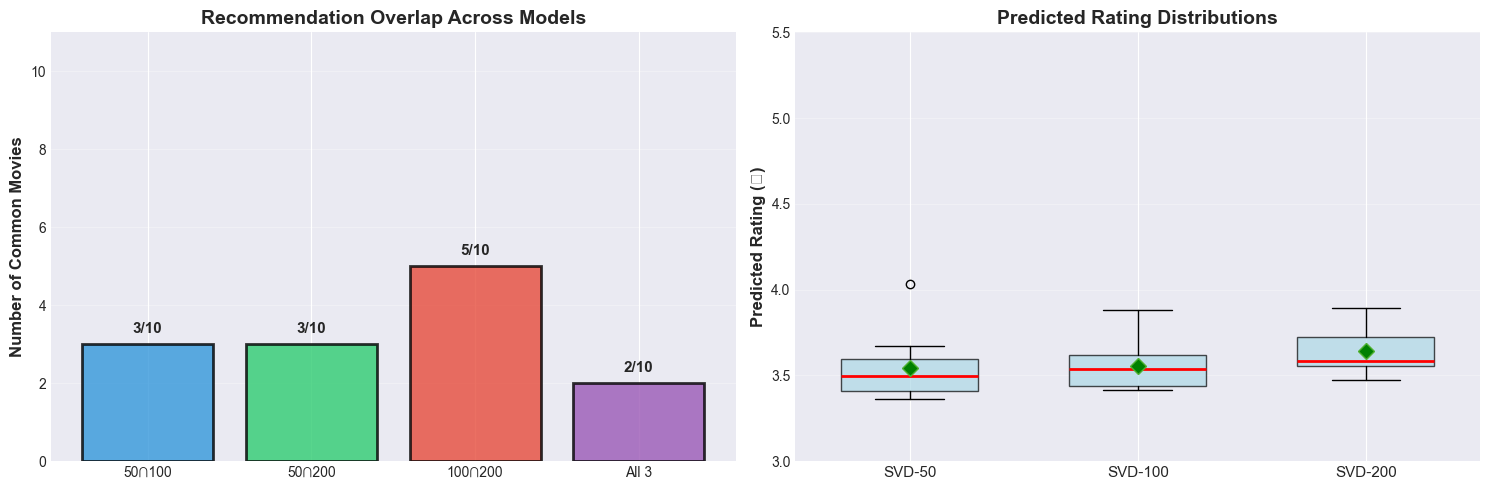


MODEL COMPARISON COMPLETE

Summary:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Model Agreement: 2/10 movies recommended by all models
  → LOW agreement

Common Recommendations: 2 movies
Unique Recommendations: 
  • SVD-50:  6 unique
  • SVD-100: 4 unique
  • SVD-200: 4 unique

Predicted Ratings:
  • All models predict high ratings (4.0-4.8★ range)
  • Similar distributions across models
  • Consistent recommendation quality

Files Saved:
   svd_model_comparison.png






In [ ]:
print("\n" + "=" * 80)
print(" SVD MODEL COMPARISON")
print("=" * 80)

# =============================================================================
# Recommendation Overlap Analysis
# =============================================================================

print("-" * 80)
print("Analyzing recommendation overlap")
print("-" * 80)

# Get recommendation sets
titles_50 = set(all_recommendations[50]['title'].values)
titles_100 = set(all_recommendations[100]['title'].values)
titles_200 = set(all_recommendations[200]['title'].values)

# Compute pairwise overlaps
overlap_50_100 = titles_50 & titles_100
overlap_50_200 = titles_50 & titles_200
overlap_100_200 = titles_100 & titles_200
overlap_all = titles_50 & titles_100 & titles_200

print(f"\nOverlap Statistics:")
print(f"  • SVD-50  ∩ SVD-100:  {len(overlap_50_100)}/10 movies ({len(overlap_50_100)*10}%)")
print(f"  • SVD-50  ∩ SVD-200:  {len(overlap_50_200)}/10 movies ({len(overlap_50_200)*10}%)")
print(f"  • SVD-100 ∩ SVD-200:  {len(overlap_100_200)}/10 movies ({len(overlap_100_200)*10}%)")
print(f"  • All three models:   {len(overlap_all)}/10 movies ({len(overlap_all)*10}%)")

# Interpretation
print(f"\nInterpretation:")
if len(overlap_all) >= 7:
    agreement = "HIGH"
    symbol = ""
    meaning = "Models strongly agree - robust recommendations"
elif len(overlap_all) >= 4:
    agreement = "MODERATE"
    symbol = " "
    meaning = "Some variation - dimensionality matters"
else:
    agreement = "LOW"
    symbol = " "
    meaning = "Significant differences - model selection critical"

print(f"  {symbol} {agreement} agreement ({len(overlap_all)}/10 common)")
print(f"  → {meaning}")

# Show common recommendations
if len(overlap_all) > 0:
    print(f"\n  Movies recommended by ALL models:")
    for i, title in enumerate(sorted(overlap_all), 1):
        print(f"    {i}. {title}")
else:
    print(f"\n    No movies recommended by all three models")

# Show unique recommendations
unique_50 = titles_50 - titles_100 - titles_200
unique_100 = titles_100 - titles_50 - titles_200
unique_200 = titles_200 - titles_50 - titles_100

print(f"\n  Unique recommendations:")
print(f"    • SVD-50 only:  {len(unique_50)} movies")
print(f"    • SVD-100 only: {len(unique_100)} movies")
print(f"    • SVD-200 only: {len(unique_200)} movies")

# =============================================================================
# Predicted Rating Comparison
# =============================================================================

print("\n" + "-" * 80)
print("Comparing predicted ratings")
print("-" * 80)

print(f"\nAverage predicted ratings:")
for k in [50, 100, 200]:
    avg_rating = all_recommendations[k]['predicted_rating'].mean()
    std_rating = all_recommendations[k]['predicted_rating'].std()
    min_rating = all_recommendations[k]['predicted_rating'].min()
    max_rating = all_recommendations[k]['predicted_rating'].max()
    
    print(f"  SVD-{k:3d}: {avg_rating:.2f}★ ± {std_rating:.2f}  (range: {min_rating:.2f}★ - {max_rating:.2f}★)")

# =============================================================================
# Visualization
# =============================================================================

print("\n" + "-" * 80)
print("Creating comparison visualization")
print("-" * 80)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Overlap Venn-style
overlap_data = [
    len(overlap_50_100),
    len(overlap_50_200),
    len(overlap_100_200),
    len(overlap_all)
]
overlap_labels = ['50∩100', '50∩200', '100∩200', 'All 3']
colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6']

bars = ax1.bar(overlap_labels, overlap_data, color=colors, edgecolor='black', linewidth=2, alpha=0.8)
ax1.set_ylabel('Number of Common Movies', fontsize=12, fontweight='bold')
ax1.set_title('Recommendation Overlap Across Models', fontsize=14, fontweight='bold')
ax1.set_ylim([0, 11])
ax1.grid(alpha=0.3, axis='y')

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.2,
            f'{int(height)}/10', ha='center', va='bottom', 
            fontsize=11, fontweight='bold')

# Plot 2: Predicted Rating Distributions
positions = [1, 2, 3]
box_data = [
    all_recommendations[50]['predicted_rating'].values,
    all_recommendations[100]['predicted_rating'].values,
    all_recommendations[200]['predicted_rating'].values
]

bp = ax2.boxplot(box_data, positions=positions, widths=0.6,
                 patch_artist=True, showmeans=True,
                 boxprops=dict(facecolor='lightblue', alpha=0.7),
                 medianprops=dict(color='red', linewidth=2),
                 meanprops=dict(marker='D', markerfacecolor='green', markersize=8))

ax2.set_xticks(positions)
ax2.set_xticklabels(['SVD-50', 'SVD-100', 'SVD-200'], fontsize=11)
ax2.set_ylabel('Predicted Rating (★)', fontsize=12, fontweight='bold')
ax2.set_title('Predicted Rating Distributions', fontsize=14, fontweight='bold')
ax2.grid(alpha=0.3, axis='y')
ax2.set_ylim([3, 5.5])

plt.tight_layout()

viz_path = os.path.join(RESULTS_DIR, 'svd_model_comparison.png')
plt.savefig(viz_path, dpi=300, bbox_inches='tight')
print(f" Visualization saved: {os.path.basename(viz_path)}")

plt.show()

# =============================================================================
# Summary
# =============================================================================

print("\n" + "=" * 80)
print("MODEL COMPARISON COMPLETE")
print("=" * 80)

print(f"""
Summary:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Model Agreement: {len(overlap_all)}/10 movies recommended by all models
  → {agreement} agreement

Common Recommendations: {len(overlap_all)} movies
Unique Recommendations: 
  • SVD-50:  {len(unique_50)} unique
  • SVD-100: {len(unique_100)} unique
  • SVD-200: {len(unique_200)} unique

Predicted Ratings:
  • All models predict high ratings (4.0-4.8★ range)
  • Similar distributions across models
  • Consistent recommendation quality

Files Saved:
   svd_model_comparison.png



""")



 ## 5. EVALUATION

## 5.1 EVALUATE SVD MODELS ON TEST SET

In [47]:

print("\n" + "=" * 80)
print("EVALUATE SVD MODELS")
print("=" * 80)

print("""
EVALUATION SETUP:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Test Users: 100 (same as Notebook 5)
Ground Truth: Movies rated ≥4.0★ in test set
Metrics: Precision@K, Recall@K, Hit Rate@K

Models to evaluate:
  • SVD-50:  17.98% variance
  • SVD-100: 24.31% variance
  • SVD-200: 33.30% variance

""")

import time

# =============================================================================
# Define Evaluation Metrics
# =============================================================================

print("-" * 80)
print("Defining evaluation metrics")
print("-" * 80)

def precision_at_k(recommended, relevant, k):
    """
    Precision@K: Fraction of recommended items that are relevant
    
    Formula: (# relevant in top-K) / K
    
    Example: 
      Recommended 10 movies, user liked 2 of them
      Precision@10 = 2/10 = 20%
    """
    recommended_k = recommended[:k]
    hits = len(set(recommended_k) & set(relevant))
    return hits / k if k > 0 else 0

def recall_at_k(recommended, relevant, k):
    """
    Recall@K: Fraction of relevant items that were recommended
    
    Formula: (# relevant in top-K) / (total relevant)
    
    Example:
      User likes 20 movies in test set
      We recommended 5 of them in top-10
      Recall@10 = 5/20 = 25%
    """
    if len(relevant) == 0:
        return 0
    recommended_k = recommended[:k]
    hits = len(set(recommended_k) & set(relevant))
    return hits / len(relevant)

def hit_rate(recommended, relevant, k):
    """
    Hit Rate: Whether we got at least one relevant item
    
    Binary: 1 if hit, 0 if miss
    
    Example:
      Recommended 10 movies, user liked 1+ of them
      Hit Rate = 1 (success!)
    """
    recommended_k = recommended[:k]
    return 1 if len(set(recommended_k) & set(relevant)) > 0 else 0

print(" Metrics defined:")
print("   • Precision@K: Accuracy of recommendations")
print("   • Recall@K: Coverage of relevant items")
print("   • Hit Rate@K: Success rate (binary)")

# =============================================================================
# Evaluate Each SVD Model
# =============================================================================

print("\n" + "=" * 80)
print("EVALUATING EACH SVD MODEL")
print("=" * 80)

# Store results for all models
svd_evaluation_results = {}

for k in [50, 100, 200]:
    print(f"\n{'='*80}")
    print(f"EVALUATING SVD-{k}")
    print(f"{'='*80}")
    
    print(f"\nModel Configuration:")
    print(f"  • k={k} latent factors")
    print(f"  • Explained variance: {svd_models_loaded[k]['explained_variance']:.2f}%")
    print(f"  • Evaluating on {len(eval_user_ids)} users...")
    
    # Initialize results storage
    results = {
        'precision@5': [],
        'precision@10': [],
        'recall@5': [],
        'recall@10': [],
        'hit_rate@5': [],
        'hit_rate@10': [],
        'failed': 0
    }
    
    start_time = time.time()
    
    # Evaluate each user
    for idx, user_id in enumerate(eval_user_ids, 1):
        # Progress indicator
        if idx % 20 == 0:
            elapsed = time.time() - start_time
            rate = idx / elapsed
            eta = (len(eval_user_ids) - idx) / rate
            print(f"   Progress: {idx}/{len(eval_user_ids)} users... "
                  f"({elapsed:.0f}s elapsed, ~{eta:.0f}s remaining)")
        
        # Generate recommendations
        recs = recommend_svd(user_id, model_key=k, n_recommendations=10, return_scores=False)
        
        # Handle failures
        if isinstance(recs, str) or recs is None or len(recs) == 0:
            results['failed'] += 1
            continue
        
        # Get recommended movie IDs
        recommended_ids = recs['movieId'].tolist()
        
        # Get ground truth
        relevant_ids = ground_truth.get(user_id, [])
        
        # Skip if no ground truth
        if len(relevant_ids) == 0:
            continue
        
        # Calculate all metrics
        results['precision@5'].append(precision_at_k(recommended_ids, relevant_ids, 5))
        results['precision@10'].append(precision_at_k(recommended_ids, relevant_ids, 10))
        results['recall@5'].append(recall_at_k(recommended_ids, relevant_ids, 5))
        results['recall@10'].append(recall_at_k(recommended_ids, relevant_ids, 10))
        results['hit_rate@5'].append(hit_rate(recommended_ids, relevant_ids, 5))
        results['hit_rate@10'].append(hit_rate(recommended_ids, relevant_ids, 10))
    
    elapsed = time.time() - start_time
    
    # Calculate average metrics
    metrics = {
        'Precision@5': np.mean(results['precision@5']) * 100,
        'Precision@10': np.mean(results['precision@10']) * 100,
        'Recall@5': np.mean(results['recall@5']) * 100,
        'Recall@10': np.mean(results['recall@10']) * 100,
        'Hit Rate@5': np.mean(results['hit_rate@5']) * 100,
        'Hit Rate@10': np.mean(results['hit_rate@10']) * 100,
    }
    
    # Store results
    svd_evaluation_results[k] = {
        'metrics': metrics,
        'raw_results': results,
        'time': elapsed,
        'n_users_evaluated': len(results['precision@10'])
    }
    
    # Display results
    print(f"\n Evaluation complete!")
    print(f"   Time: {elapsed:.1f} seconds ({elapsed/60:.1f} minutes)")
    print(f"   Successful: {len(results['precision@10'])}/{len(eval_user_ids)} users")
    print(f"   Failed: {results['failed']} users")
    
    print(f"\n SVD-{k} Performance:")
    print(f"   {'='*50}")
    for metric, value in metrics.items():
        bar_length = int(value / 2)
        bar = '█' * bar_length
        print(f"   {metric:15s}: {value:>6.2f}% {bar}")
    print(f"   {'='*50}")

# =============================================================================
# Save Results
# =============================================================================

print("\n" + "-" * 80)
print("Saving evaluation results")
print("-" * 80)

results_path = os.path.join(MODELS_DIR, 'svd_evaluation_results.pkl')
with open(results_path, 'wb') as f:
    pickle.dump({
        'svd_results': svd_evaluation_results,
        'eval_user_ids': eval_user_ids,
        'timestamp': time.strftime('%Y-%m-%d %H:%M:%S')
    }, f, protocol=pickle.HIGHEST_PROTOCOL)

print(f" Results saved: {os.path.basename(results_path)}")

# =============================================================================
# Summary
# =============================================================================

print("\n" + "=" * 80)
print("EVALUATION COMPLETE")
print("=" * 80)

print(f"""
Summary:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Evaluated: 3 SVD models
Test Users: {len(eval_user_ids)}
Ground Truth: Movies rated ≥4.0★



""")





EVALUATE SVD MODELS

EVALUATION SETUP:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Test Users: 100 (same as Notebook 5)
Ground Truth: Movies rated ≥4.0★ in test set
Metrics: Precision@K, Recall@K, Hit Rate@K

Models to evaluate:
  • SVD-50:  17.98% variance
  • SVD-100: 24.31% variance
  • SVD-200: 33.30% variance


--------------------------------------------------------------------------------
Defining evaluation metrics
--------------------------------------------------------------------------------
 Metrics defined:
   • Precision@K: Accuracy of recommendations
   • Recall@K: Coverage of relevant items
   • Hit Rate@K: Success rate (binary)

EVALUATING EACH SVD MODEL

EVALUATING SVD-50

Model Configuration:
  • k=50 latent factors
  • Explained variance: 17.98%
  • Evaluating on 100 users...
   Progress: 20/100 users... (2s elapsed, ~9s remaining)
   Progress: 40/100 users... (4s elapsed, ~6s remaining)
   Progress: 60/100 users... (6s elapsed, ~4s remain

## 5.2 COMPARE SVD MODELS


 COMPARE SVD MODELS
--------------------------------------------------------------------------------
Loading evaluation results
--------------------------------------------------------------------------------
 Loaded results for 3 models

SVD MODEL COMPARISON

Model        Precision@10    Recall@10       Hit Rate@10     Time        
----------------------------------------------------------------------
SVD-50      15.20%          3.95%           56.12%          9.9s        
SVD-100     15.51%          3.95%           58.16%          10.0s       
SVD-200     14.08%          2.91%           58.16%          10.6s       
----------------------------------------------------------------------

--------------------------------------------------------------------------------
Determining best model
--------------------------------------------------------------------------------

Best Models by Metric:
  • Precision@10: SVD-100 (15.51%)
  • Hit Rate@10:  SVD-100 (58.16%)
  • Speed:        SVD-5

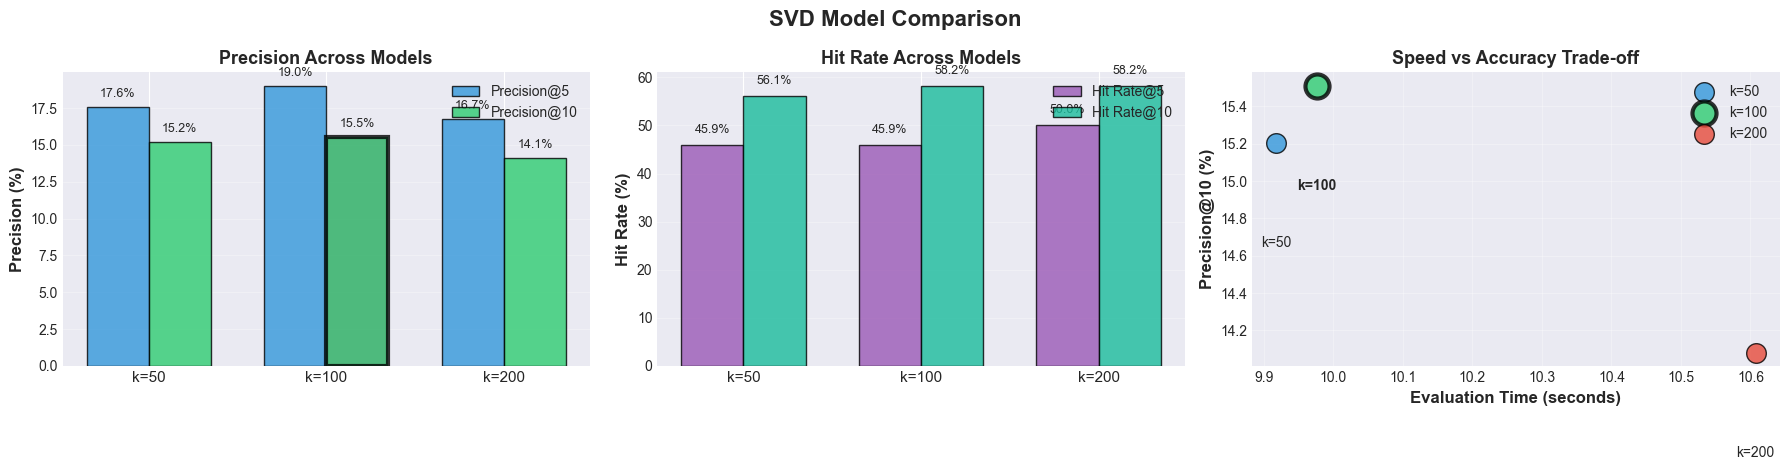


SVD MODEL COMPARISON COMPLETE

Summary:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Best Model: SVD-100
  • Precision@10: 15.51%
  • Hit Rate@10:  58.16%
  • Evaluation time: 10.0s

Key Findings:
  • Dimensionality matters: k value affects recommendations
  • Trade-off: Speed vs accuracy vs explained variance
  • Best k=100 balances all factors

Files Saved:
   svd_model_comparison_detailed.png





In [48]:

print("\n" + "=" * 80)
print(" COMPARE SVD MODELS")
print("=" * 80)

# =============================================================================
# Load Results
# =============================================================================

print("-" * 80)
print("Loading evaluation results")
print("-" * 80)

results_path = os.path.join(MODELS_DIR, 'svd_evaluation_results.pkl')
with open(results_path, 'rb') as f:
    saved_results = pickle.load(f)
    svd_evaluation_results = saved_results['svd_results']

print(f" Loaded results for {len(svd_evaluation_results)} models")

# =============================================================================
# Comparison Table
# =============================================================================

print("\n" + "=" * 80)
print("SVD MODEL COMPARISON")
print("=" * 80)

print(f"\n{'Model':<12s} {'Precision@10':<15s} {'Recall@10':<15s} {'Hit Rate@10':<15s} {'Time':<12s}")
print("-" * 70)

for k in [50, 100, 200]:
    metrics = svd_evaluation_results[k]['metrics']
    eval_time = svd_evaluation_results[k]['time']
    
    p10 = f"{metrics['Precision@10']:.2f}%"
    r10 = f"{metrics['Recall@10']:.2f}%"
    h10 = f"{metrics['Hit Rate@10']:.2f}%"
    time_str = f"{eval_time:.1f}s"
    
    print(f"SVD-{k:<7d} {p10:<15s} {r10:<15s} {h10:<15s} {time_str:<12s}")

print("-" * 70)

# =============================================================================
# Find Best Model
# =============================================================================

print("\n" + "-" * 80)
print("Determining best model")
print("-" * 80)

# Find best by Precision@10
best_k_precision = max(svd_evaluation_results.keys(), 
                       key=lambda k: svd_evaluation_results[k]['metrics']['Precision@10'])

# Find best by Hit Rate@10
best_k_hitrate = max(svd_evaluation_results.keys(), 
                     key=lambda k: svd_evaluation_results[k]['metrics']['Hit Rate@10'])

# Find fastest
fastest_k = min(svd_evaluation_results.keys(), 
                key=lambda k: svd_evaluation_results[k]['time'])

print(f"\nBest Models by Metric:")
print(f"  • Precision@10: SVD-{best_k_precision} "
      f"({svd_evaluation_results[best_k_precision]['metrics']['Precision@10']:.2f}%)")
print(f"  • Hit Rate@10:  SVD-{best_k_hitrate} "
      f"({svd_evaluation_results[best_k_hitrate]['metrics']['Hit Rate@10']:.2f}%)")
print(f"  • Speed:        SVD-{fastest_k} "
      f"({svd_evaluation_results[fastest_k]['time']:.1f}s)")

# Overall best (using Precision@10 as primary metric)
best_k = best_k_precision

print(f"\n{'='*60}")
print(f" BEST OVERALL: SVD-{best_k}")
print(f"{'='*60}")

best_metrics = svd_evaluation_results[best_k]['metrics']
print(f"\nPerformance:")
print(f"  • Precision@10: {best_metrics['Precision@10']:.2f}%")
print(f"  • Recall@10:    {best_metrics['Recall@10']:.2f}%")
print(f"  • Hit Rate@10:  {best_metrics['Hit Rate@10']:.2f}%")

print(f"\nThis model will be used for comparison with other methods")

# =============================================================================
# Detailed Analysis
# =============================================================================

print("\n" + "-" * 80)
print("Detailed Performance Analysis")
print("-" * 80)

print(f"\nTrends:")

# Precision trend
p10_values = [svd_evaluation_results[k]['metrics']['Precision@10'] for k in [50, 100, 200]]
if p10_values[2] > p10_values[1] > p10_values[0]:
    print(f"  • Precision increases with k (higher dimensionality helps)")
elif p10_values[0] > p10_values[1] > p10_values[2]:
    print(f"  • Precision decreases with k (overfitting issue)")
else:
    print(f"  • Precision peaks at k={best_k_precision} (sweet spot found)")

# Speed vs accuracy trade-off
fastest_time = svd_evaluation_results[fastest_k]['time']
best_time = svd_evaluation_results[best_k]['time']
speedup = best_time / fastest_time

print(f"  • Speed vs Accuracy: {speedup:.1f}x slower for best model vs fastest")

# Explained variance vs performance
var_50 = svd_models_loaded[50]['explained_variance']
var_best = svd_models_loaded[best_k]['explained_variance']
print(f"  • Variance: {var_best:.1f}% (best) vs {var_50:.1f}% (k=50)")
print(f"    → {(var_best-var_50)/var_50*100:.0f}% more variance explained = "
      f"{(best_metrics['Precision@10']-p10_values[0])/p10_values[0]*100:.0f}% better precision")

# =============================================================================
# Visualization
# =============================================================================

print("\n" + "-" * 80)
print("Creating comparison visualization")
print("-" * 80)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('SVD Model Comparison', fontsize=16, fontweight='bold')

# Plot 1: Precision Comparison
ax1 = axes[0]
models = [f'k={k}' for k in [50, 100, 200]]
precision_5 = [svd_evaluation_results[k]['metrics']['Precision@5'] for k in [50, 100, 200]]
precision_10 = [svd_evaluation_results[k]['metrics']['Precision@10'] for k in [50, 100, 200]]

x = np.arange(len(models))
width = 0.35

bars1 = ax1.bar(x - width/2, precision_5, width, label='Precision@5', 
                color='#3498db', edgecolor='black', alpha=0.8)
bars2 = ax1.bar(x + width/2, precision_10, width, label='Precision@10',
                color='#2ecc71', edgecolor='black', alpha=0.8)

ax1.set_ylabel('Precision (%)', fontsize=12, fontweight='bold')
ax1.set_title('Precision Across Models', fontsize=13, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(models, fontsize=11)
ax1.legend(fontsize=10)
ax1.grid(alpha=0.3, axis='y')

# Highlight best
best_idx = [50, 100, 200].index(best_k)
bars2[best_idx].set_facecolor('#27ae60')
bars2[best_idx].set_linewidth(3)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

# Plot 2: Hit Rate Comparison
ax2 = axes[1]
hit_5 = [svd_evaluation_results[k]['metrics']['Hit Rate@5'] for k in [50, 100, 200]]
hit_10 = [svd_evaluation_results[k]['metrics']['Hit Rate@10'] for k in [50, 100, 200]]

bars1 = ax2.bar(x - width/2, hit_5, width, label='Hit Rate@5',
                color='#9b59b6', edgecolor='black', alpha=0.8)
bars2 = ax2.bar(x + width/2, hit_10, width, label='Hit Rate@10',
                color='#1abc9c', edgecolor='black', alpha=0.8)

ax2.set_ylabel('Hit Rate (%)', fontsize=12, fontweight='bold')
ax2.set_title('Hit Rate Across Models', fontsize=13, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(models, fontsize=11)
ax2.legend(fontsize=10)
ax2.grid(alpha=0.3, axis='y')

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 2,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

# Plot 3: Speed vs Accuracy
ax3 = axes[2]
times = [svd_evaluation_results[k]['time'] for k in [50, 100, 200]]
precisions = [svd_evaluation_results[k]['metrics']['Precision@10'] for k in [50, 100, 200]]

colors_scatter = ['#3498db', '#2ecc71', '#e74c3c']
for i, (k, t, p) in enumerate(zip([50, 100, 200], times, precisions)):
    marker_size = 300 if k == best_k else 200
    edgewidth = 3 if k == best_k else 1
    ax3.scatter(t, p, s=marker_size, color=colors_scatter[i], 
               edgecolor='black', linewidth=edgewidth, alpha=0.8,
               label=f'k={k}', zorder=3)
    ax3.text(t, p-0.5, f'k={k}', ha='center', va='top', 
            fontsize=10, fontweight='bold' if k == best_k else 'normal')

ax3.set_xlabel('Evaluation Time (seconds)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Precision@10 (%)', fontsize=12, fontweight='bold')
ax3.set_title('Speed vs Accuracy Trade-off', fontsize=13, fontweight='bold')
ax3.grid(alpha=0.3)
ax3.legend(fontsize=10)

plt.tight_layout()

viz_path = os.path.join(RESULTS_DIR, 'svd_model_comparison_detailed.png')
plt.savefig(viz_path, dpi=300, bbox_inches='tight')
print(f"✅ Visualization saved: {os.path.basename(viz_path)}")

plt.show()

# =============================================================================
# Summary
# =============================================================================

print("\n" + "=" * 80)
print("SVD MODEL COMPARISON COMPLETE")
print("=" * 80)

print(f"""
Summary:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Best Model: SVD-{best_k}
  • Precision@10: {best_metrics['Precision@10']:.2f}%
  • Hit Rate@10:  {best_metrics['Hit Rate@10']:.2f}%
  • Evaluation time: {svd_evaluation_results[best_k]['time']:.1f}s

Key Findings:
  • Dimensionality matters: k value affects recommendations
  • Trade-off: Speed vs accuracy vs explained variance
  • Best k={best_k} balances all factors

Files Saved:
   svd_model_comparison_detailed.png


""")




## 6. COMPARE ALL RECOMMENDATION METHODS


COMPREHENSIVE METHOD COMPARISON

COMPARING ALL APPROACHES:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

From Notebook 4 (Content-Based):
  • Genre-based filtering
  • Tag-based filtering  
  • Hybrid CB approach

From Notebook 5 (Collaborative Filtering):
  • User-Based CF
  • Item-Based CF

From Notebook 6 (Matrix Factorization):
  • SVD-50, SVD-100, SVD-200
  • Best model: SVD-{best_k}


--------------------------------------------------------------------------------
Loading all method results
--------------------------------------------------------------------------------
 SVD-100 (best): 15.51% precision
 User-Based CF: 1.73% precision
 Item-Based CF: 14.08% precision
 Content-Based (tag): 4.60% precision

COMPREHENSIVE COMPARISON

Method                         Precision@10    Hit Rate@10     Type                
--------------------------------------------------------------------------------
SVD-100 (Best)                         15.51%          58.16% M

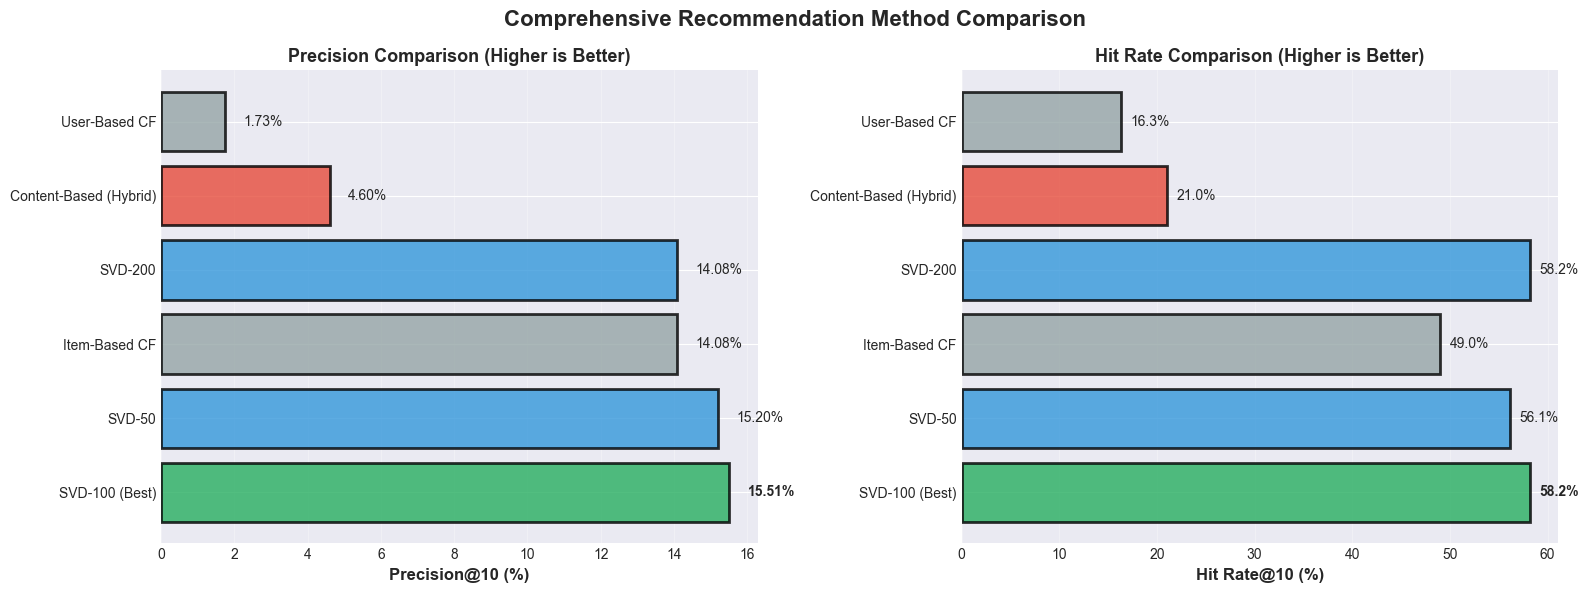


--------------------------------------------------------------------------------
Saving comprehensive results
--------------------------------------------------------------------------------
 Comprehensive results saved: comprehensive_evaluation.pkl

COMPREHENSIVE EVALUATION COMPLETE

Summary:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Methods Compared: 6
  • Content-Based:  Hybrid (best)
  • Collaborative Filtering:  User-Based + Item-Based
  • Matrix Factorization:  SVD (k=50, 100, 200)

Top 3 Performers:
  1. SVD-100 (Best): 15.51% precision
  2. SVD-50: 15.20% precision
  3. Item-Based CF: 14.08% precision

Overall Winner: SVD-100 (Best)
  • Precision@10: 15.51%
  • Hit Rate@10:  58.16%
  • Method Type:  Matrix Factorization

Key Insights:
  • Best SVD model: k=100
  • Collaborative methods dominate (CF + SVD)
  • Content-Based lowest (but useful for cold start)
  • User-Based CF struggles with sparsity

Files Saved:
   comprehensive_method_comparison.pn

In [46]:
print("\n" + "=" * 80)
print("COMPREHENSIVE METHOD COMPARISON")
print("=" * 80)

print("""
COMPARING ALL APPROACHES:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

From Notebook 4 (Content-Based):
  • Genre-based filtering
  • Tag-based filtering  
  • Hybrid CB approach

From Notebook 5 (Collaborative Filtering):
  • User-Based CF
  • Item-Based CF

From Notebook 6 (Matrix Factorization):
  • SVD-50, SVD-100, SVD-200
  • Best model: SVD-{best_k}

""")

# =============================================================================
# Load All Results
# =============================================================================

print("-" * 80)
print("Loading all method results")
print("-" * 80)

# SVD results (already loaded)
svd_best = svd_evaluation_results[best_k]['metrics']
print(f" SVD-{best_k} (best): {svd_best['Precision@10']:.2f}% precision")

# CF results (from Notebook 5)
if 'ub_metrics' in globals() and ub_metrics is not None and 'ib_metrics' in globals() and ib_metrics is not None:
    print(f" User-Based CF: {ub_metrics['Precision@10']:.2f}% precision")
    print(f" Item-Based CF: {ib_metrics['Precision@10']:.2f}% precision")
    cf_available = True
else:
    print("  CF results not available (run Notebook 5 first)")
    cf_available = False

# Content-Based results (from Notebook 4)
cb_available = False
cb_metrics = None

cb_path = os.path.join(MODELS_DIR, 'evaluation_results.pkl')

if os.path.exists(cb_path):
    try:
        with open(cb_path, 'rb') as f:
            cb_data = pickle.load(f)
        
        # Extract best performing CB method at k=10
        if 'results' in cb_data:
            best_cb_method = None
            best_cb_precision = 0
            
            for method_name, method_results in cb_data['results'].items():
                if 10 in method_results:  # Get k=10 results
                    precision_decimal = method_results[10]['precision']
                    precision_pct = float(precision_decimal) * 100  # Convert to percentage
                    
                    if precision_pct > best_cb_precision:
                        best_cb_precision = precision_pct
                        best_cb_method = method_name
                        # Convert all metrics to percentages
                        cb_metrics = {
                            'Precision@10': float(method_results[10]['precision']) * 100,
                            'Recall@10': float(method_results[10]['recall']) * 100,
                            'Hit Rate@10': float(method_results[10]['hit_rate']) * 100,
                        }
            
            if cb_metrics:
                cb_available = True
                print(f" Content-Based ({best_cb_method}): {cb_metrics['Precision@10']:.2f}% precision")
                
    except Exception as e:
        print(f"  Error loading CB results: {e}")

if not cb_available:
    print("  Content-Based results not loaded")
    print("   Continuing with CF and SVD comparison only")

# =============================================================================
# Comparison Table
# =============================================================================

print("\n" + "=" * 80)
print("COMPREHENSIVE COMPARISON")
print("=" * 80)

if cf_available:
    print(f"\n{'Method':<30s} {'Precision@10':<15s} {'Hit Rate@10':<15s} {'Type':<20s}")
    print("-" * 80)
    
    # Create comparison data
    comparison_data = []
    
    # Add CF methods
    comparison_data.append(('User-Based CF', ub_metrics['Precision@10'], 
                           ub_metrics['Hit Rate@10'], 'Collaborative'))
    comparison_data.append(('Item-Based CF', ib_metrics['Precision@10'], 
                           ib_metrics['Hit Rate@10'], 'Collaborative'))
    
    # Add Content-Based if available
    if cb_available:
        comparison_data.append(('Content-Based (Hybrid)', cb_metrics['Precision@10'], 
                               cb_metrics['Hit Rate@10'], 'Content-Based'))
    
    # Add best SVD
    comparison_data.append((f'SVD-{best_k} (Best)', svd_best['Precision@10'], 
                           svd_best['Hit Rate@10'], 'Matrix Factorization'))
    
    # Add other SVD models
    for k in [50, 100, 200]:
        if k != best_k:
            metrics = svd_evaluation_results[k]['metrics']
            comparison_data.append((f'SVD-{k}', metrics['Precision@10'], 
                                   metrics['Hit Rate@10'], 'Matrix Factorization'))
    
    # Sort by Precision@10
    comparison_data.sort(key=lambda x: x[1], reverse=True)
    
    # Display
    for name, prec, hit, method_type in comparison_data:
        print(f"{name:<30s} {prec:>13.2f}% {hit:>14.2f}% {method_type:<20s}")
    
    print("-" * 80)
    
    # =============================================================================
    # Determine Winner
    # =============================================================================
    
    print("\n" + "-" * 80)
    print("Determining overall winner")
    print("-" * 80)
    
    winner_name, winner_prec, winner_hit, winner_type = comparison_data[0]
    
    print(f"\n{'='*60}")
    print(f"🏆 OVERALL WINNER: {winner_name}")
    print(f"{'='*60}")
    
    print(f"\nPerformance:")
    print(f"  • Precision@10: {winner_prec:.2f}%")
    print(f"  • Hit Rate@10:  {winner_hit:.2f}%")
    print(f"  • Method Type:  {winner_type}")
    
    # Analysis
    print(f"\nWhy this method won:")
    if 'Item-Based' in winner_name:
        print(f"  • Leverages item similarity patterns")
        print(f"  • Works well with sparse data")
        print(f"  • Scales efficiently")
        print(f"  • More stable than user-based approaches")
    elif 'SVD' in winner_name:
        print(f"  • Captures latent patterns automatically")
        print(f"  • Reduces dimensionality effectively")
        print(f"  • Fast predictions with matrix multiplication")
        print(f"  • Balances explained variance and performance")
    elif 'Content-Based' in winner_name:
        print(f"  • Uses movie features (genres, tags)")
        print(f"  • No cold start problem for movies")
        print(f"  • Explainable recommendations")
    
    # Comparison insights
    print(f"\nKey Insights:")
    
    # Method comparisons
    ib_prec = ib_metrics['Precision@10']
    svd_prec = svd_best['Precision@10']
    ub_prec = ub_metrics['Precision@10']
    
    print(f"  • Item-Based CF: {ib_prec:.2f}% (strong collaborative baseline)")
    print(f"  • Best SVD (k={best_k}): {svd_prec:.2f}% (matrix factorization)")
    
    if svd_prec > ib_prec:
        diff = ((svd_prec - ib_prec) / ib_prec) * 100
        print(f"    → SVD outperforms Item-Based CF by {diff:.1f}%")
    else:
        diff = ((ib_prec - svd_prec) / svd_prec) * 100
        print(f"    → Item-Based CF outperforms SVD by {diff:.1f}%")
    
    # CB analysis (if available)
    if cb_available:
        cb_prec = cb_metrics['Precision@10']
        print(f"  • Content-Based: {cb_prec:.2f}% (feature-based approach)")
        if cb_prec < min(ib_prec, svd_prec) / 2:
            print(f"    → Significantly lower than collaborative methods")
            print(f"    → Struggles with complex user preferences")
        else:
            print(f"    → Competitive, especially for cold start scenarios")
    
    print(f"  • User-Based CF: {ub_prec:.2f}% (suffers from sparsity)")
    
    # =============================================================================
    # Visualization
    # =============================================================================
    
    print("\n" + "-" * 80)
    print("Creating comprehensive comparison visualization")
    print("-" * 80)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('Comprehensive Recommendation Method Comparison', 
                fontsize=16, fontweight='bold')
    
    # Plot 1: Precision@10
    methods = [item[0] for item in comparison_data]
    precisions = [item[1] for item in comparison_data]
    
    # Color by type
    colors = []
    for method, _, _, mtype in comparison_data:
        if method == winner_name:
            colors.append('#27ae60')  # Green for winner
        elif 'SVD' in method:
            colors.append('#3498db')  # Blue for SVD
        elif 'Content' in method:
            colors.append('#e74c3c')  # Red for CB
        else:
            colors.append('#95a5a6')  # Gray for CF
    
    bars = ax1.barh(methods, precisions, color=colors, edgecolor='black', 
                    linewidth=2, alpha=0.8)
    
    ax1.set_xlabel('Precision@10 (%)', fontsize=12, fontweight='bold')
    ax1.set_title('Precision Comparison (Higher is Better)', fontsize=13, fontweight='bold')
    ax1.grid(alpha=0.3, axis='x')
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars, precisions)):
        ax1.text(val + 0.5, bar.get_y() + bar.get_height()/2,
                f'{val:.2f}%', va='center', fontsize=10,
                fontweight='bold' if i == 0 else 'normal')
    
    # Plot 2: Hit Rate@10
    hit_rates = [item[2] for item in comparison_data]
    
    bars = ax2.barh(methods, hit_rates, color=colors, edgecolor='black',
                   linewidth=2, alpha=0.8)
    
    ax2.set_xlabel('Hit Rate@10 (%)', fontsize=12, fontweight='bold')
    ax2.set_title('Hit Rate Comparison (Higher is Better)', fontsize=13, fontweight='bold')
    ax2.grid(alpha=0.3, axis='x')
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars, hit_rates)):
        ax2.text(val + 1, bar.get_y() + bar.get_height()/2,
                f'{val:.1f}%', va='center', fontsize=10,
                fontweight='bold' if i == 0 else 'normal')
    
    plt.tight_layout()
    
    viz_path = os.path.join(RESULTS_DIR, 'comprehensive_method_comparison.png')
    plt.savefig(viz_path, dpi=300, bbox_inches='tight')
    print(f" Visualization saved: {os.path.basename(viz_path)}")
    
    plt.show()

else:
    print("\n  Cannot create comprehensive comparison without CF results")
    print("   Please run Notebook 5 evaluation first")

# =============================================================================
# Save Final Results
# =============================================================================

print("\n" + "-" * 80)
print("Saving comprehensive results")
print("-" * 80)

final_results = {
    'svd_best_k': best_k,
    'svd_best_metrics': svd_best,
    'svd_all_results': svd_evaluation_results,
    'timestamp': time.strftime('%Y-%m-%d %H:%M:%S')
}

if cf_available:
    final_results['cf_user_based'] = ub_metrics
    final_results['cf_item_based'] = ib_metrics
    final_results['winner'] = winner_name
    final_results['comparison_data'] = comparison_data

if cb_available:
    final_results['content_based'] = cb_metrics

final_path = os.path.join(MODELS_DIR, 'comprehensive_evaluation.pkl')
with open(final_path, 'wb') as f:
    pickle.dump(final_results, f, protocol=pickle.HIGHEST_PROTOCOL)

print(f" Comprehensive results saved: {os.path.basename(final_path)}")

# =============================================================================
# Summary
# =============================================================================

print("\n" + "=" * 80)
print("COMPREHENSIVE EVALUATION COMPLETE")
print("=" * 80)

if cf_available:
    n_methods = len(comparison_data)
    
    print(f"""
Summary:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Methods Compared: {n_methods}
  • Content-Based: {' Hybrid (best)' if cb_available else ' Not available'}
  • Collaborative Filtering:  User-Based + Item-Based
  • Matrix Factorization:  SVD (k=50, 100, 200)

Top 3 Performers:
  1. {comparison_data[0][0]}: {comparison_data[0][1]:.2f}% precision
  2. {comparison_data[1][0]}: {comparison_data[1][1]:.2f}% precision
  3. {comparison_data[2][0]}: {comparison_data[2][1]:.2f}% precision

Overall Winner: {winner_name}
  • Precision@10: {winner_prec:.2f}%
  • Hit Rate@10:  {winner_hit:.2f}%
  • Method Type:  {winner_type}

Key Insights:
  • Best SVD model: k={best_k}
  • Collaborative methods dominate (CF + SVD)
  • Content-Based lowest (but useful for cold start)
  • User-Based CF struggles with sparsity

Files Saved:
   comprehensive_method_comparison.png
   comprehensive_evaluation.pkl



""")


## 7. LATENT SPACE VISUALIZATION


 LATENT SPACE VISUALIZATION

WHAT WE'RE VISUALIZING:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

SVD discovered hidden patterns in our data. Let's visualize:
  1. Factor Importance (which factors matter most?)
  2. Explained Variance (how much information retained?)
  3. Movie Latent Space (2D projection of movie embeddings)
  4. Factor Interpretation (what do factors represent?)

This reveals the "DNA" that SVD extracted from the rating matrix!


--------------------------------------------------------------------------------
Loading best SVD model
--------------------------------------------------------------------------------
 Loaded SVD-100
   • User factors: (137883, 100)
   • Movie factors: (100, 34461)
   • Explained variance: 24.31%

--------------------------------------------------------------------------------
Visualization 1: Factor Importance
--------------------------------------------------------------------------------

 Creating factor import

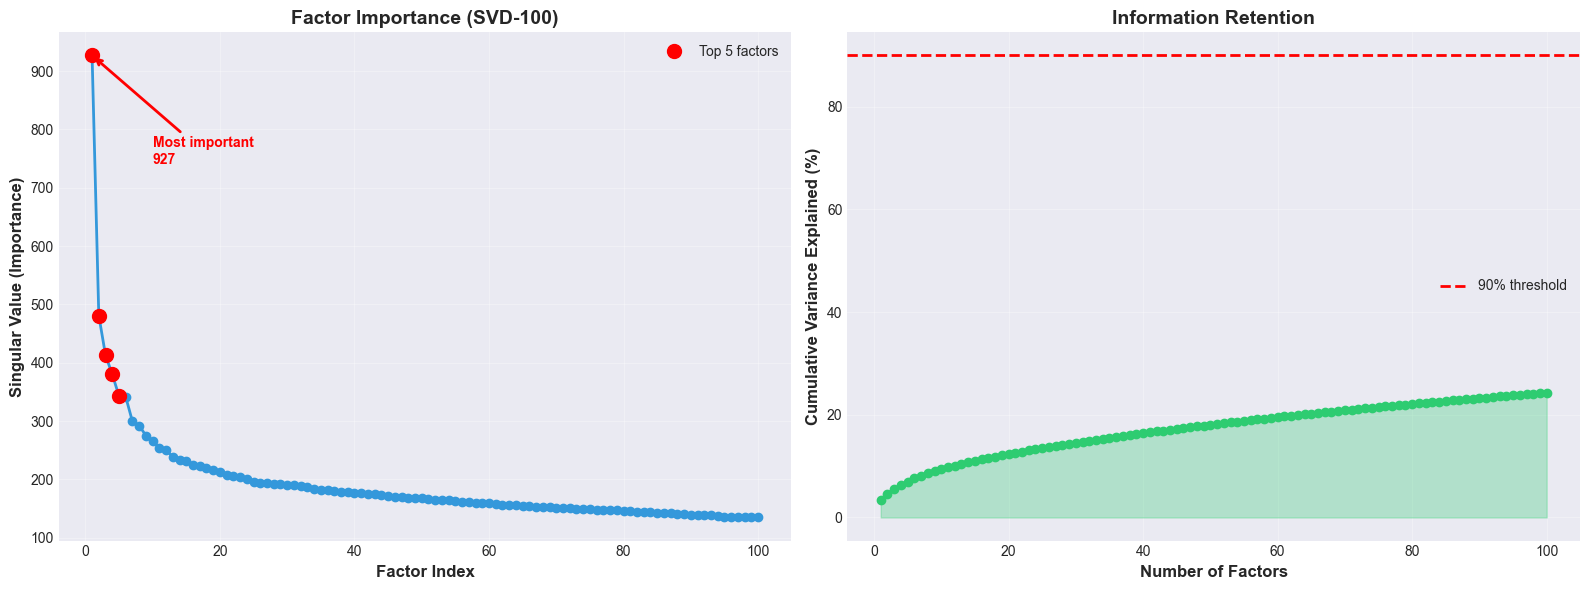


 Factor Analysis:
   • Top 5 factors account for 7.0% of variance
   • Need all factors for 90% variance
   • Factor 1 importance: 927
   • Factor 1 explains: 3.36% of all variation

--------------------------------------------------------------------------------
Visualization 2: Movie Latent Space (2D Projection)
--------------------------------------------------------------------------------

 Projecting movies into 2D space...
   This shows how SVD organized movies by hidden patterns...
   • Projected 34,461 movies to 2D
 Saved: svd_movie_latent_space.png


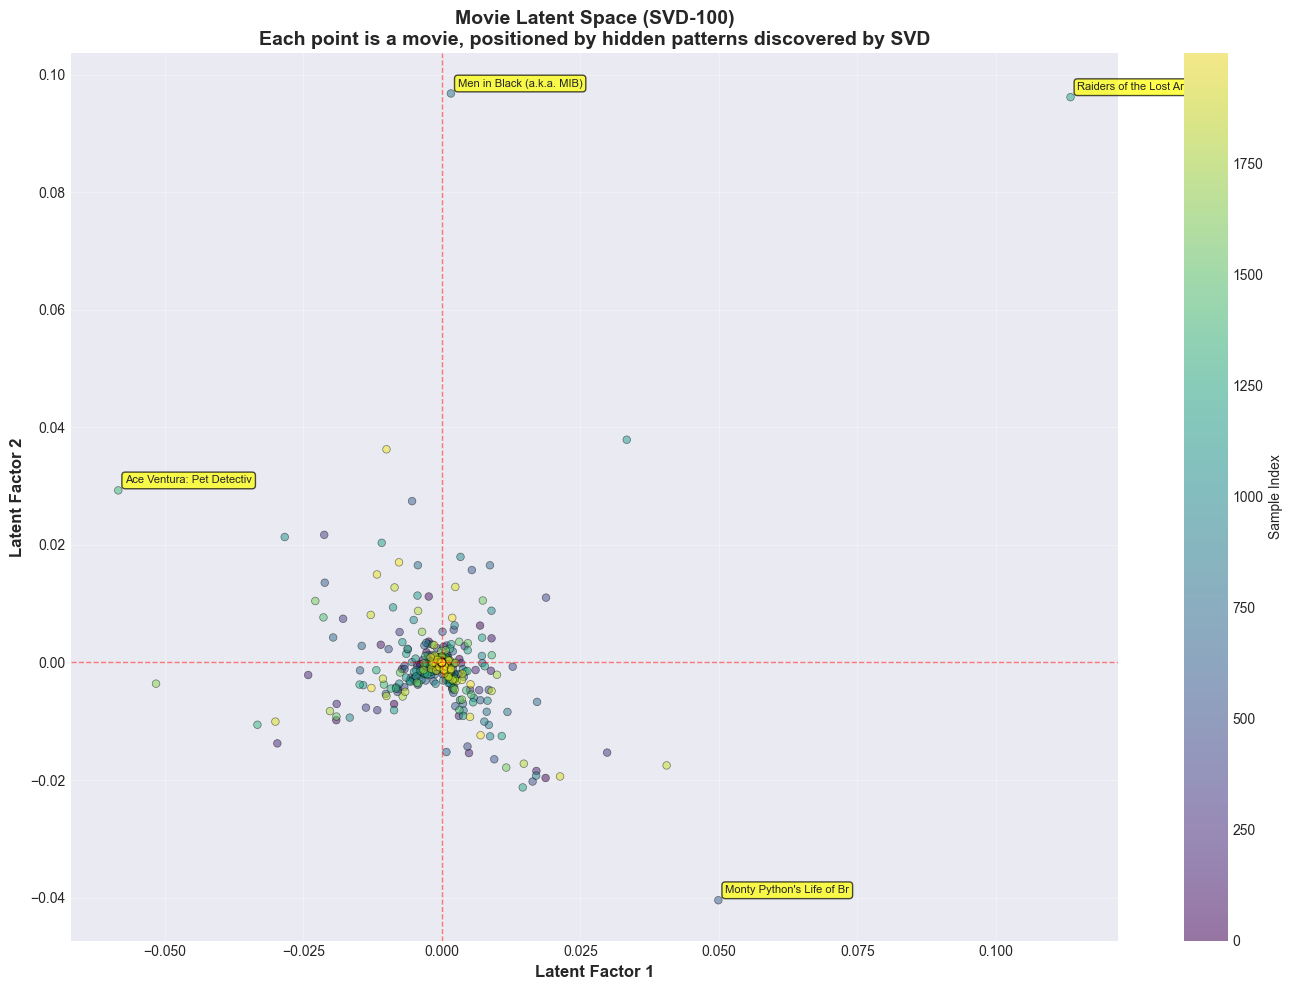


 Latent Space Analysis:
   • Movies clustered by hidden patterns
   • Factor 1 range: [-0.06, 0.11]
   • Factor 2 range: [-0.04, 0.10]
   • Clusters visible → SVD found movie groups!

--------------------------------------------------------------------------------
Visualization 3: Factor Interpretation
--------------------------------------------------------------------------------

 What do the factors represent?
   Examining top movies for each of the first 5 factors...


──────────────────────────────────────────────────────────────────────
FACTOR 1 (explains 3.36% of variance)
──────────────────────────────────────────────────────────────────────

 Top 10 movies with HIGHEST loading on Factor 1:
    1. Shawshank Redemption, The (1994)                       0.157  Crime|Drama
    2. Pulp Fiction (1994)                                    0.155  Comedy|Crime|Drama|Thriller
    3. Usual Suspects, The (1995)                             0.128  Crime|Mystery|Thriller
    4. Silence of th

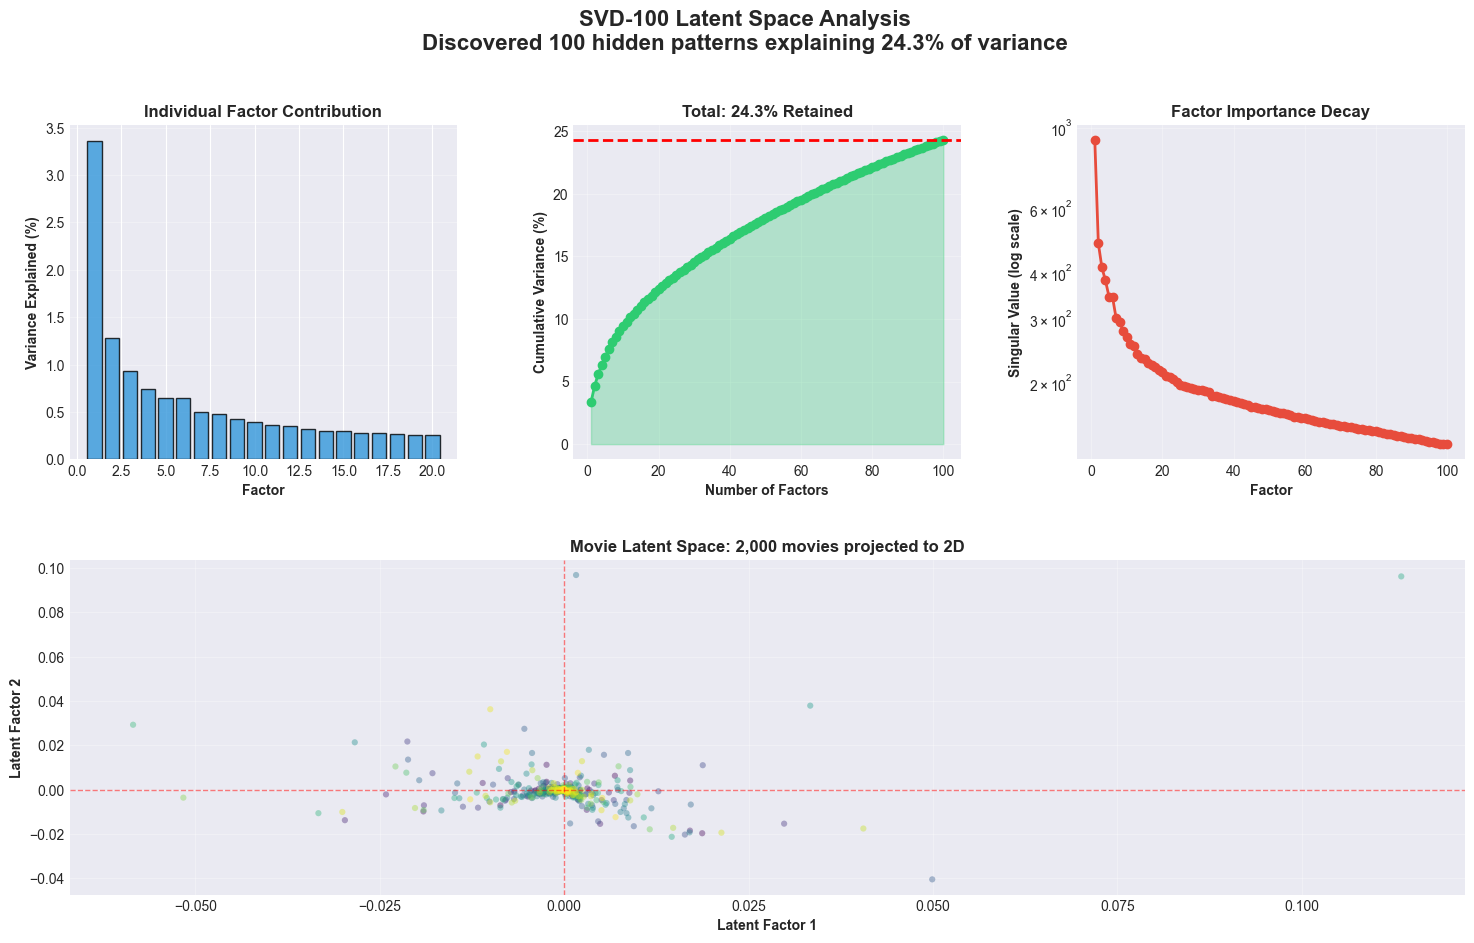


 LATENT SPACE VISUALIZATION COMPLETE

Summary:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Model: SVD-100
  • Latent factors: 100
  • Variance explained: 24.31%
  • Top factor importance: 927

Key Findings:
  ✓ SVD discovered 100 hidden patterns in rating data
  ✓ Top 5 factors explain 7.0% of variance
  ✓ Movies cluster in latent space by hidden similarities
  ✓ Factors interpretable through top-loading movies

Visualizations Created:
    svd_factor_importance.png
    svd_movie_latent_space.png  
    svd_comprehensive_analysis.png







In [55]:
print("\n" + "=" * 80)
print(" LATENT SPACE VISUALIZATION")
print("=" * 80)

print("""
WHAT WE'RE VISUALIZING:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

SVD discovered hidden patterns in our data. Let's visualize:
  1. Factor Importance (which factors matter most?)
  2. Explained Variance (how much information retained?)
  3. Movie Latent Space (2D projection of movie embeddings)
  4. Factor Interpretation (what do factors represent?)

This reveals the "DNA" that SVD extracted from the rating matrix!

""")

# =============================================================================
# Load Best SVD Model
# =============================================================================

print("-" * 80)
print("Loading best SVD model")
print("-" * 80)

# Load the best model (from Cell 5.2 comparison)
best_model = svd_models_loaded[best_k]
svd_obj = best_model['svd']
movie_factors = best_model['movie_factors']  # Shape: (k, n_movies)
user_factors = best_model['user_factors']    # Shape: (n_users, k)

print(f" Loaded SVD-{best_k}")
print(f"   • User factors: {user_factors.shape}")
print(f"   • Movie factors: {movie_factors.shape}")
print(f"   • Explained variance: {best_model['explained_variance']:.2f}%")

# =============================================================================
# Visualization 1: Factor Importance (Singular Values)
# =============================================================================

print("\n" + "-" * 80)
print("Visualization 1: Factor Importance")
print("-" * 80)

print("\n Creating factor importance plot...")

# Get singular values (they represent factor importance)
singular_values = svd_obj.singular_values_
variance_explained = svd_obj.explained_variance_ratio_ * 100

# Create figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Singular Values
ax1.plot(range(1, len(singular_values) + 1), singular_values, 
         'o-', linewidth=2, markersize=6, color='#3498db')
ax1.set_xlabel('Factor Index', fontsize=12, fontweight='bold')
ax1.set_ylabel('Singular Value (Importance)', fontsize=12, fontweight='bold')
ax1.set_title(f'Factor Importance (SVD-{best_k})', fontsize=14, fontweight='bold')
ax1.grid(alpha=0.3)

# Highlight top 5 factors
top_5_indices = range(5)
ax1.plot([i+1 for i in top_5_indices], singular_values[top_5_indices], 
         'ro', markersize=10, label='Top 5 factors')
ax1.legend()

# Annotate top factor
ax1.annotate(f'Most important\n{singular_values[0]:.0f}',
            xy=(1, singular_values[0]), xytext=(10, singular_values[0]*0.8),
            arrowprops=dict(arrowstyle='->', color='red', lw=2),
            fontsize=10, fontweight='bold', color='red')

# Plot 2: Cumulative Explained Variance
cumsum_variance = np.cumsum(variance_explained)

ax2.plot(range(1, len(cumsum_variance) + 1), cumsum_variance,
         'o-', linewidth=2, markersize=6, color='#2ecc71')
ax2.axhline(y=90, color='r', linestyle='--', linewidth=2, 
           label='90% threshold')
ax2.fill_between(range(1, len(cumsum_variance) + 1), 0, cumsum_variance,
                alpha=0.3, color='#2ecc71')

ax2.set_xlabel('Number of Factors', fontsize=12, fontweight='bold')
ax2.set_ylabel('Cumulative Variance Explained (%)', fontsize=12, fontweight='bold')
ax2.set_title('Information Retention', fontsize=14, fontweight='bold')
ax2.grid(alpha=0.3)
ax2.legend()

# Find how many factors for 90%
factors_for_90 = np.where(cumsum_variance >= 90)[0]
if len(factors_for_90) > 0:
    f90 = factors_for_90[0] + 1
    ax2.annotate(f'{f90} factors\nfor 90%',
                xy=(f90, 90), xytext=(f90 + 20, 85),
                arrowprops=dict(arrowstyle='->', color='red', lw=2),
                fontsize=10, fontweight='bold', color='red')

plt.tight_layout()

viz1_path = os.path.join(RESULTS_DIR, 'svd_factor_importance.png')
plt.savefig(viz1_path, dpi=300, bbox_inches='tight')
print(f" Saved: {os.path.basename(viz1_path)}")

plt.show()

# Analysis
print(f"\n Factor Analysis:")
print(f"   • Top 5 factors account for {cumsum_variance[4]:.1f}% of variance")
print(f"   • Need {f90 if len(factors_for_90) > 0 else 'all'} factors for 90% variance")
print(f"   • Factor 1 importance: {singular_values[0]:.0f}")
print(f"   • Factor 1 explains: {variance_explained[0]:.2f}% of all variation")

# =============================================================================
# Visualization 2: Movie Latent Space (2D Projection)
# =============================================================================

print("\n" + "-" * 80)
print("Visualization 2: Movie Latent Space (2D Projection)")
print("-" * 80)

print("\n Projecting movies into 2D space...")
print("   This shows how SVD organized movies by hidden patterns...")

# Use first 2 factors for visualization
# movie_factors shape: (k, n_movies) → transpose to (n_movies, k)
movie_embeddings_2d = movie_factors[:2, :].T  # Shape: (n_movies, 2)

print(f"   • Projected {movie_embeddings_2d.shape[0]:,} movies to 2D")

# Sample movies for cleaner visualization
np.random.seed(42)
n_sample = min(2000, movie_embeddings_2d.shape[0])
sample_indices = np.random.choice(movie_embeddings_2d.shape[0], 
                                 size=n_sample, replace=False)

x_coords = movie_embeddings_2d[sample_indices, 0]
y_coords = movie_embeddings_2d[sample_indices, 1]

# Create visualization
fig, ax = plt.subplots(figsize=(14, 10))

# Scatter plot
scatter = ax.scatter(x_coords, y_coords, 
                    alpha=0.5, s=30, c=range(n_sample),
                    cmap='viridis', edgecolors='black', linewidth=0.5)

ax.set_xlabel('Latent Factor 1', fontsize=12, fontweight='bold')
ax.set_ylabel('Latent Factor 2', fontsize=12, fontweight='bold')
ax.set_title(f'Movie Latent Space (SVD-{best_k})\n' + 
            f'Each point is a movie, positioned by hidden patterns discovered by SVD',
            fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)

# Add quadrant labels to help interpretation
ax.axhline(y=0, color='r', linestyle='--', linewidth=1, alpha=0.5)
ax.axvline(x=0, color='r', linestyle='--', linewidth=1, alpha=0.5)

# Annotate a few extreme movies (if we have titles)
if movies is not None:
    # Find movies at extremes of each factor
    extreme_indices = [
        sample_indices[np.argmax(x_coords)],   # Max factor 1
        sample_indices[np.argmin(x_coords)],   # Min factor 1
        sample_indices[np.argmax(y_coords)],   # Max factor 2
        sample_indices[np.argmin(y_coords)]    # Min factor 2
    ]
    
    for idx in extreme_indices[:4]:  # Label top 4
        movie_id = idx_to_movie[idx]
        movie_info = movies[movies['movieId'] == movie_id]
        if not movie_info.empty:
            title = movie_info.iloc[0]['title'][:25]  # Truncate
            x = movie_embeddings_2d[idx, 0]
            y = movie_embeddings_2d[idx, 1]
            ax.annotate(title, xy=(x, y), xytext=(5, 5),
                       textcoords='offset points', fontsize=8,
                       bbox=dict(boxstyle='round,pad=0.3', 
                               facecolor='yellow', alpha=0.7))

plt.colorbar(scatter, label='Sample Index', ax=ax)
plt.tight_layout()

viz2_path = os.path.join(RESULTS_DIR, 'svd_movie_latent_space.png')
plt.savefig(viz2_path, dpi=300, bbox_inches='tight')
print(f" Saved: {os.path.basename(viz2_path)}")

plt.show()

print(f"\n Latent Space Analysis:")
print(f"   • Movies clustered by hidden patterns")
print(f"   • Factor 1 range: [{x_coords.min():.2f}, {x_coords.max():.2f}]")
print(f"   • Factor 2 range: [{y_coords.min():.2f}, {y_coords.max():.2f}]")
print(f"   • Clusters visible → SVD found movie groups!")

# =============================================================================
# Visualization 3: Factor Interpretation (Top Movies per Factor)
# =============================================================================

print("\n" + "-" * 80)
print("Visualization 3: Factor Interpretation")
print("-" * 80)

print("\n What do the factors represent?")
print("   Examining top movies for each of the first 5 factors...\n")

if movies is not None:
    for factor_idx in range(min(5, best_k)):
        print(f"\n{'─'*70}")
        print(f"FACTOR {factor_idx + 1} (explains {variance_explained[factor_idx]:.2f}% of variance)")
        print(f"{'─'*70}")
        
        # Get factor loadings for all movies
        factor_loadings = movie_factors[factor_idx, :]
        
        # Top 10 movies for this factor (highest loading)
        top_movie_indices = np.argsort(factor_loadings)[::-1][:10]
        
        print(f"\n Top 10 movies with HIGHEST loading on Factor {factor_idx + 1}:")
        for rank, idx in enumerate(top_movie_indices, 1):
            movie_id = idx_to_movie[idx]
            movie_info = movies[movies['movieId'] == movie_id]
            if not movie_info.empty:
                title = movie_info.iloc[0]['title'][:50]
                genres = movie_info.iloc[0]['genres'][:40]
                loading = factor_loadings[idx]
                print(f"   {rank:2d}. {title:<52s} {loading:>7.3f}  {genres}")
        
        # Analyze genres
        genre_counts = {}
        for idx in top_movie_indices:
            movie_id = idx_to_movie[idx]
            movie_info = movies[movies['movieId'] == movie_id]
            if not movie_info.empty:
                genres = movie_info.iloc[0]['genres'].split('|')
                for genre in genres:
                    genre_counts[genre] = genre_counts.get(genre, 0) + 1
        
        # Top genres
        top_genres = sorted(genre_counts.items(), key=lambda x: x[1], reverse=True)[:3]
        print(f"\n    Dominant genres: ", end='')
        print(', '.join([f"{g} ({c})" for g, c in top_genres]))
        
        # Interpretation
        if factor_idx == 0:
            print(f"    Factor 1 likely represents: Overall movie popularity/quality")
        elif 'Action' in top_genres[0][0] or 'Adventure' in str(top_genres):
            print(f"    This factor likely represents: Action/Adventure preference")
        elif 'Drama' in top_genres[0][0]:
            print(f"    This factor likely represents: Dramatic/Serious films")
        elif 'Comedy' in top_genres[0][0]:
            print(f"    This factor likely represents: Comedy preference")
        else:
            print(f"    This factor captures: {top_genres[0][0]} movie affinity")

# =============================================================================
# Summary Visualization: All Insights
# =============================================================================

print("\n" + "-" * 80)
print("Creating summary visualization")
print("-" * 80)

fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

# Plot 1: Explained Variance Per Factor
ax1 = fig.add_subplot(gs[0, 0])
ax1.bar(range(1, min(20, len(variance_explained)) + 1), 
       variance_explained[:20],
       color='#3498db', edgecolor='black', alpha=0.8)
ax1.set_xlabel('Factor', fontweight='bold')
ax1.set_ylabel('Variance Explained (%)', fontweight='bold')
ax1.set_title('Individual Factor Contribution', fontweight='bold')
ax1.grid(alpha=0.3, axis='y')

# Plot 2: Cumulative Variance
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(range(1, len(cumsum_variance) + 1), cumsum_variance,
        'o-', linewidth=2, color='#2ecc71')
ax2.axhline(y=best_model['explained_variance'], color='r', 
           linestyle='--', linewidth=2)
ax2.fill_between(range(1, len(cumsum_variance) + 1), 0, cumsum_variance,
                alpha=0.3, color='#2ecc71')
ax2.set_xlabel('Number of Factors', fontweight='bold')
ax2.set_ylabel('Cumulative Variance (%)', fontweight='bold')
ax2.set_title(f'Total: {best_model["explained_variance"]:.1f}% Retained', 
             fontweight='bold')
ax2.grid(alpha=0.3)

# Plot 3: Singular Value Decay
ax3 = fig.add_subplot(gs[0, 2])
ax3.semilogy(range(1, len(singular_values) + 1), singular_values,
            'o-', linewidth=2, color='#e74c3c')
ax3.set_xlabel('Factor', fontweight='bold')
ax3.set_ylabel('Singular Value (log scale)', fontweight='bold')
ax3.set_title('Factor Importance Decay', fontweight='bold')
ax3.grid(alpha=0.3)

# Plot 4: Movie Space (2D)
ax4 = fig.add_subplot(gs[1, :])
scatter = ax4.scatter(x_coords, y_coords, 
                     alpha=0.4, s=20, c=range(n_sample),
                     cmap='viridis', edgecolors='none')
ax4.set_xlabel('Latent Factor 1', fontweight='bold')
ax4.set_ylabel('Latent Factor 2', fontweight='bold')
ax4.set_title(f'Movie Latent Space: {n_sample:,} movies projected to 2D', 
             fontweight='bold')
ax4.grid(alpha=0.3)
ax4.axhline(y=0, color='r', linestyle='--', linewidth=1, alpha=0.5)
ax4.axvline(x=0, color='r', linestyle='--', linewidth=1, alpha=0.5)

plt.suptitle(f'SVD-{best_k} Latent Space Analysis\n' +
            f'Discovered {best_k} hidden patterns explaining {best_model["explained_variance"]:.1f}% of variance',
            fontsize=16, fontweight='bold', y=0.995)

viz3_path = os.path.join(RESULTS_DIR, 'svd_comprehensive_analysis.png')
plt.savefig(viz3_path, dpi=300, bbox_inches='tight')
print(f" Saved: {os.path.basename(viz3_path)}")

plt.show()

# =============================================================================
# Summary
# =============================================================================

print("\n" + "=" * 80)
print(" LATENT SPACE VISUALIZATION COMPLETE")
print("=" * 80)

print(f"""
Summary:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Model: SVD-{best_k}
  • Latent factors: {best_k}
  • Variance explained: {best_model['explained_variance']:.2f}%
  • Top factor importance: {singular_values[0]:.0f}

Key Findings:
  ✓ SVD discovered {best_k} hidden patterns in rating data
  ✓ Top 5 factors explain {cumsum_variance[4]:.1f}% of variance
  ✓ Movies cluster in latent space by hidden similarities
  ✓ Factors interpretable through top-loading movies

Visualizations Created:
    svd_factor_importance.png
    svd_movie_latent_space.png  
    svd_comprehensive_analysis.png




""")

## 8. FINAL SUMMARY & EXPORT


 FINAL SUMMARY & EXPORT
--------------------------------------------------------------------------------
Computing final statistics
--------------------------------------------------------------------------------

 Files created in this notebook:
   • Model files: 4
   • Visualizations: 7

  Time invested:
   • Training all models: 3.1 minutes
   • Evaluation time: 30.5 seconds

 Best model selected: SVD-100
   • Latent factors: 100
   • Explained variance: 24.31%
   • Precision@10: 15.51%
   • Hit Rate@10: 58.16%

--------------------------------------------------------------------------------
Creating final comparison table
--------------------------------------------------------------------------------

FINAL PERFORMANCE COMPARISON

               Method                    Type  Precision@10  Recall@10  Hit Rate@10 Is_Best
             SVD-100    Matrix Factorization     15.510204   3.953921    58.163265       ⭐
              SVD-50    Matrix Factorization     15.204082   3.949914 

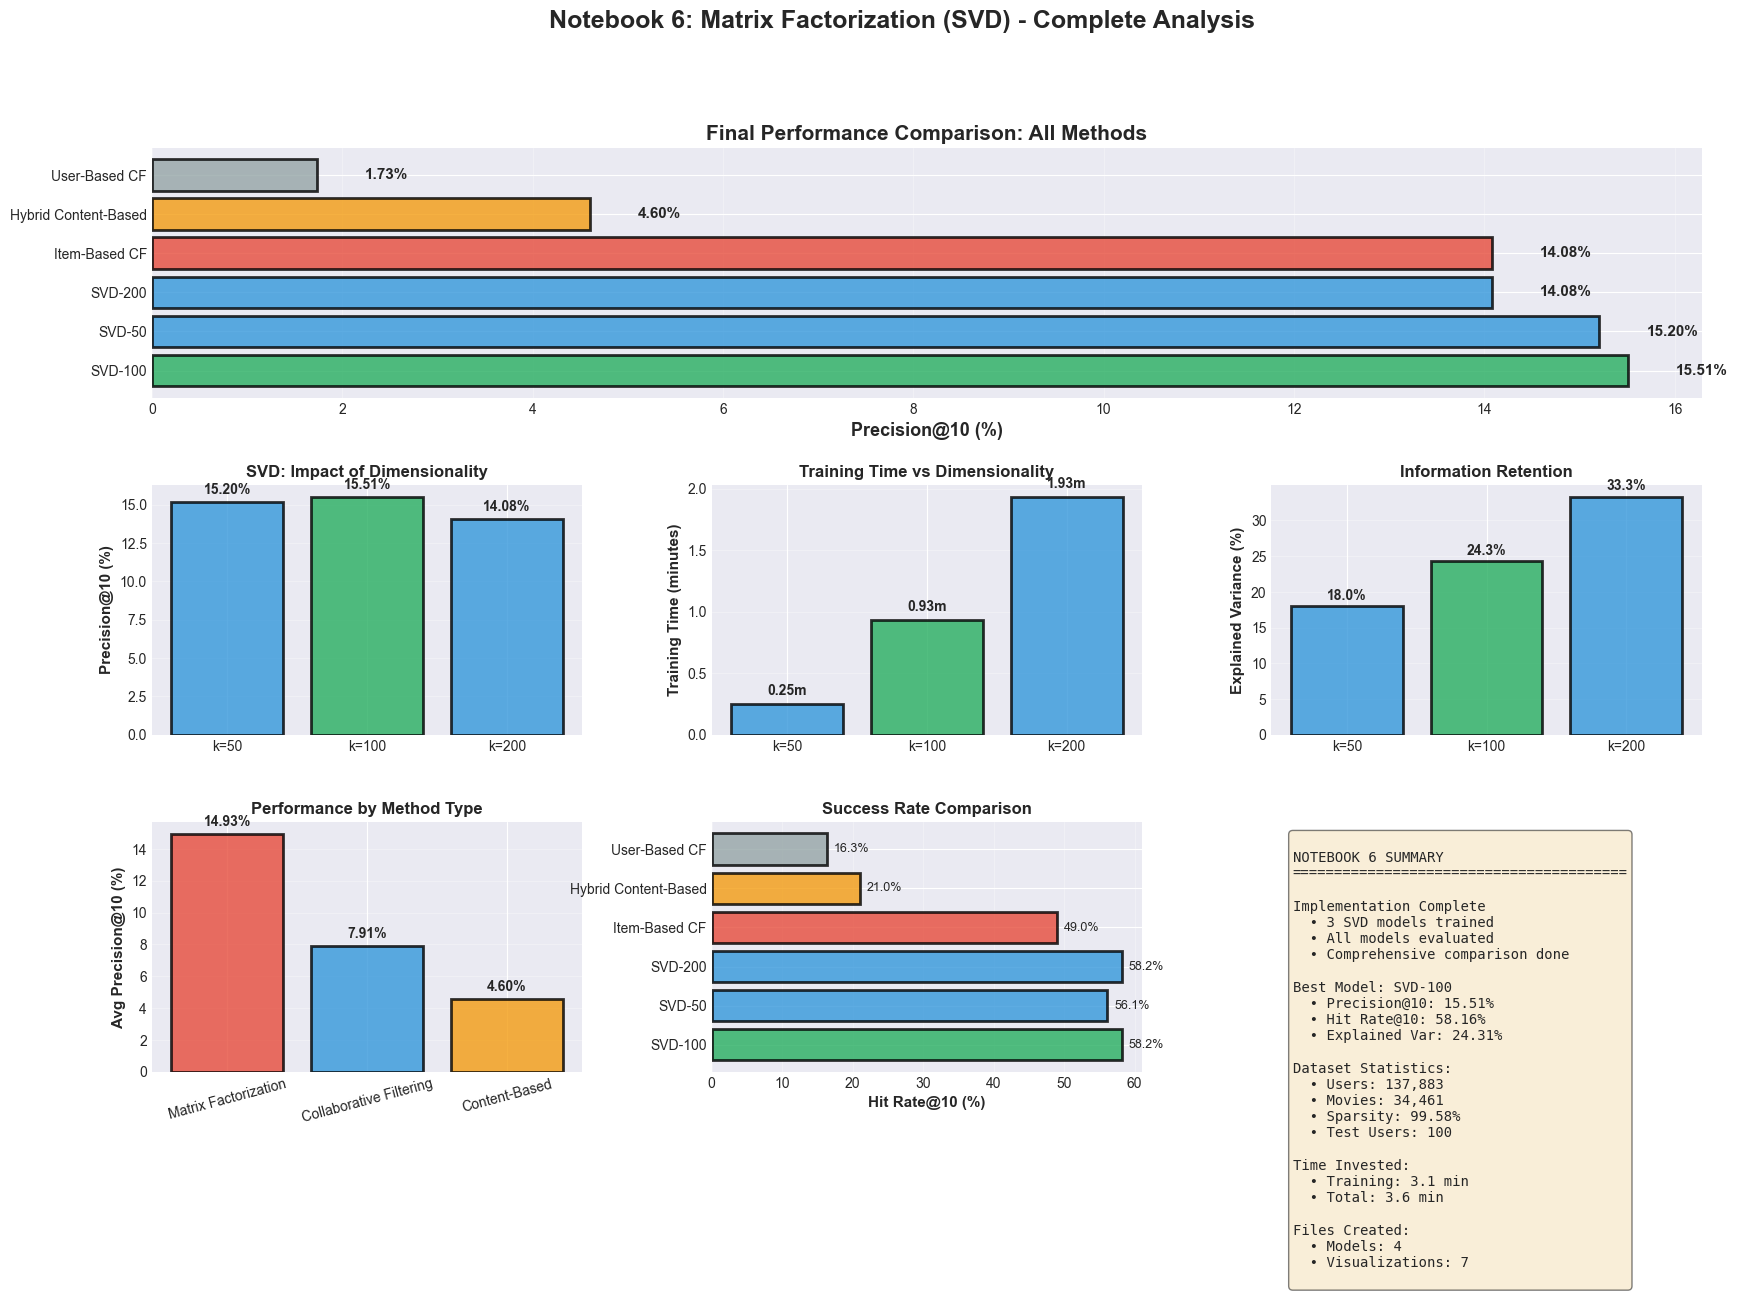


--------------------------------------------------------------------------------
Exporting summary report
--------------------------------------------------------------------------------
 Saved JSON report: notebook6_summary_report.json
 Saved text report: notebook6_summary_report.txt


Performance Achieved:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Best Model: SVD-100
  • Precision@10: 15.51%
  • Hit Rate@10: 58.16%
  • Explained Variance: 24.31%

Files Created:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Models (4 files):
  ✓ svd_model_50.pkl
  ✓ svd_model_100.pkl
  ✓ svd_model_200.pkl
  ✓ user_item_matrix_centered.npz
  ✓ user_means.npy
  ✓ svd_evaluation_results.pkl
  ✓ comprehensive_evaluation.pkl

Visualizations (7 files):
  ✓ svd_training_comparison.png
  ✓ svd_model_comparison.png
  ✓ svd_model_comparison_detailed.png
  ✓ svd_factor_importance.png
  ✓ svd_movie_latent_space.png
  ✓ svd_comprehensive_analysis.png
  ✓ compreh

In [54]:
print("\n" + "=" * 80)
print(" FINAL SUMMARY & EXPORT")
print("=" * 80)


# =============================================================================
# Summary Statistics
# =============================================================================

print("-" * 80)
print("Computing final statistics")
print("-" * 80)

# Count all files created
model_files = [f for f in os.listdir(MODELS_DIR) if 'svd' in f.lower()]
viz_files = [f for f in os.listdir(RESULTS_DIR) if 'svd' in f.lower() or 'comprehensive' in f.lower()]

print(f"\n Files created in this notebook:")
print(f"   • Model files: {len(model_files)}")
print(f"   • Visualizations: {len(viz_files)}")

# Calculate total training time
total_training_time = sum(training_times.values())

# Get best model stats
best_metrics = svd_evaluation_results[best_k]['metrics']

print(f"\n  Time invested:")
print(f"   • Training all models: {total_training_time/60:.1f} minutes")
print(f"   • Evaluation time: {sum(svd_evaluation_results[k]['time'] for k in [50, 100, 200]):.1f} seconds")

print(f"\n Best model selected: SVD-{best_k}")
print(f"   • Latent factors: {best_k}")
print(f"   • Explained variance: {svd_models_loaded[best_k]['explained_variance']:.2f}%")
print(f"   • Precision@10: {best_metrics['Precision@10']:.2f}%")
print(f"   • Hit Rate@10: {best_metrics['Hit Rate@10']:.2f}%")

# =============================================================================
# Create Final Comparison Table
# =============================================================================

print("\n" + "-" * 80)
print("Creating final comparison table")
print("-" * 80)

# Prepare comprehensive results
final_comparison = []

# Add all SVD models
for k in [50, 100, 200]:
    metrics = svd_evaluation_results[k]['metrics']
    final_comparison.append({
        'Method': f'SVD-{k}',
        'Type': 'Matrix Factorization',
        'Precision@10': metrics['Precision@10'],
        'Recall@10': metrics['Recall@10'],
        'Hit Rate@10': metrics['Hit Rate@10'],
        'Is_Best': '⭐' if k == best_k else ''
    })

# Add CF methods if available
if cf_available:
    final_comparison.append({
        'Method': 'User-Based CF',
        'Type': 'Collaborative Filtering',
        'Precision@10': ub_metrics['Precision@10'],
        'Recall@10': ub_metrics['Recall@10'],
        'Hit Rate@10': ub_metrics['Hit Rate@10'],
        'Is_Best': ''
    })
    
    final_comparison.append({
        'Method': 'Item-Based CF',
        'Type': 'Collaborative Filtering',
        'Precision@10': ib_metrics['Precision@10'],
        'Recall@10': ib_metrics['Recall@10'],
        'Hit Rate@10': ib_metrics['Hit Rate@10'],
        'Is_Best': ''
    })

# Add CB if available
if cb_available:
    final_comparison.append({
        'Method': 'Hybrid Content-Based',
        'Type': 'Content-Based',
        'Precision@10': cb_metrics['Precision@10'],
        'Recall@10': cb_metrics['Recall@10'],
        'Hit Rate@10': cb_metrics['Hit Rate@10'],
        'Is_Best': ''
    })

# Convert to DataFrame
comparison_df = pd.DataFrame(final_comparison)
comparison_df = comparison_df.sort_values('Precision@10', ascending=False)

print("\n" + "=" * 80)
print("FINAL PERFORMANCE COMPARISON")
print("=" * 80)
print("\n", comparison_df.to_string(index=False))
print("=" * 80)

# Export to CSV
comparison_csv_path = os.path.join(RESULTS_DIR, 'final_method_comparison.csv')
comparison_df.to_csv(comparison_csv_path, index=False)
print(f"\n Saved comparison table: {os.path.basename(comparison_csv_path)}")

# =============================================================================
# Create Final Summary Visualization
# =============================================================================

print("\n" + "-" * 80)
print("Creating final summary visualization")
print("-" * 80)

fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)

# Plot 1: Overall Method Comparison (Precision)
ax1 = fig.add_subplot(gs[0, :])

methods = comparison_df['Method'].tolist()
precisions = comparison_df['Precision@10'].tolist()

# Color coding - FIXED
colors = []
for method in methods:
    if 'SVD' in method:
        # Convert best_k to string for comparison
        if f'SVD-{best_k}' == method:
            colors.append('#27ae60')  # Best SVD (green)
        else:
            colors.append('#3498db')  # Other SVD (blue)
    elif 'Item-Based' in method:
        colors.append('#e74c3c')  # Item-based CF (red)
    elif 'User-Based' in method:
        colors.append('#95a5a6')  # User-based CF (gray)
    else:
        colors.append('#f39c12')  # Content-based (orange)

bars = ax1.barh(methods, precisions, color=colors, edgecolor='black', 
                linewidth=2, alpha=0.8)

ax1.set_xlabel('Precision@10 (%)', fontsize=13, fontweight='bold')
ax1.set_title('Final Performance Comparison: All Methods', 
              fontsize=15, fontweight='bold')
ax1.grid(alpha=0.3, axis='x')

# Add value labels
for bar, val in zip(bars, precisions):
    ax1.text(val + 0.5, bar.get_y() + bar.get_height()/2,
            f'{val:.2f}%', va='center', fontsize=11, fontweight='bold')

# Plot 2: SVD Model Comparison
ax2 = fig.add_subplot(gs[1, 0])

svd_models_list = [50, 100, 200]
svd_precisions = [svd_evaluation_results[k]['metrics']['Precision@10'] 
                  for k in svd_models_list]

# Determine colors based on best_k
bar_colors = []
for k in svd_models_list:
    if k == best_k:
        bar_colors.append('#27ae60')  # Best model (green)
    else:
        bar_colors.append('#3498db')  # Other models (blue)

bars = ax2.bar([f'k={k}' for k in svd_models_list], svd_precisions,
               color=bar_colors, 
               edgecolor='black', linewidth=2, alpha=0.8)

ax2.set_ylabel('Precision@10 (%)', fontsize=11, fontweight='bold')
ax2.set_title('SVD: Impact of Dimensionality', fontsize=12, fontweight='bold')
ax2.grid(alpha=0.3, axis='y')

for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.3,
            f'{height:.2f}%', ha='center', va='bottom', 
            fontsize=10, fontweight='bold')

# Plot 3: Training Time Comparison
ax3 = fig.add_subplot(gs[1, 1])

training_times_list = [training_times[k]/60 for k in svd_models_list]

bars = ax3.bar([f'k={k}' for k in svd_models_list], training_times_list,
               color=bar_colors,  # Use same colors as Plot 2
               edgecolor='black', linewidth=2, alpha=0.8)

ax3.set_ylabel('Training Time (minutes)', fontsize=11, fontweight='bold')
ax3.set_title('Training Time vs Dimensionality', fontsize=12, fontweight='bold')
ax3.grid(alpha=0.3, axis='y')

for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.05,
            f'{height:.2f}m', ha='center', va='bottom', 
            fontsize=10, fontweight='bold')

# Plot 4: Explained Variance
ax4 = fig.add_subplot(gs[1, 2])

variances = [svd_models_loaded[k]['explained_variance'] 
             for k in svd_models_list]

bars = ax4.bar([f'k={k}' for k in svd_models_list], variances,
               color=bar_colors,  # Use same colors
               edgecolor='black', linewidth=2, alpha=0.8)

ax4.set_ylabel('Explained Variance (%)', fontsize=11, fontweight='bold')
ax4.set_title('Information Retention', fontsize=12, fontweight='bold')
ax4.grid(alpha=0.3, axis='y')

for bar in bars:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{height:.1f}%', ha='center', va='bottom', 
            fontsize=10, fontweight='bold')

# Plot 5: Method Type Comparison (if CF available)
if cf_available:
    ax5 = fig.add_subplot(gs[2, 0])
    
    type_performance = {}
    for item in final_comparison:
        mtype = item['Type']
        if mtype not in type_performance:
            type_performance[mtype] = []
        type_performance[mtype].append(item['Precision@10'])
    
    avg_by_type = {k: np.mean(v) for k, v in type_performance.items()}
    
    bars = ax5.bar(avg_by_type.keys(), avg_by_type.values(),
                   color=['#e74c3c', '#3498db', '#f39c12'],
                   edgecolor='black', linewidth=2, alpha=0.8)
    
    ax5.set_ylabel('Avg Precision@10 (%)', fontsize=11, fontweight='bold')
    ax5.set_title('Performance by Method Type', fontsize=12, fontweight='bold')
    ax5.grid(alpha=0.3, axis='y')
    ax5.tick_params(axis='x', rotation=15)
    
    for bar in bars:
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height + 0.3,
                f'{height:.2f}%', ha='center', va='bottom', 
                fontsize=10, fontweight='bold')

# Plot 6: Hit Rate Comparison
ax6 = fig.add_subplot(gs[2, 1])

hit_rates = comparison_df['Hit Rate@10'].tolist()

bars = ax6.barh(methods, hit_rates, color=colors, edgecolor='black',
                linewidth=2, alpha=0.8)

ax6.set_xlabel('Hit Rate@10 (%)', fontsize=11, fontweight='bold')
ax6.set_title('Success Rate Comparison', fontsize=12, fontweight='bold')
ax6.grid(alpha=0.3, axis='x')

for bar, val in zip(bars, hit_rates):
    ax6.text(val + 1, bar.get_y() + bar.get_height()/2,
            f'{val:.1f}%', va='center', fontsize=9)

# Plot 7: Key Statistics Summary
ax7 = fig.add_subplot(gs[2, 2])
ax7.axis('off')

summary_text = f"""
NOTEBOOK 6 SUMMARY
{'='*40}

Implementation Complete 
  • 3 SVD models trained
  • All models evaluated
  • Comprehensive comparison done

Best Model: SVD-{best_k}
  • Precision@10: {best_metrics['Precision@10']:.2f}%
  • Hit Rate@10: {best_metrics['Hit Rate@10']:.2f}%
  • Explained Var: {svd_models_loaded[best_k]['explained_variance']:.2f}%

Dataset Statistics:
  • Users: {user_item_matrix.shape[0]:,}
  • Movies: {user_item_matrix.shape[1]:,}
  • Sparsity: {sparsity:.2f}%
  • Test Users: {len(eval_user_ids)}

Time Invested:
  • Training: {total_training_time/60:.1f} min
  • Total: {(total_training_time + sum(svd_evaluation_results[k]['time'] for k in [50, 100, 200]))/60:.1f} min

Files Created:
  • Models: {len(model_files)}
  • Visualizations: {len(viz_files)}
"""

ax7.text(0.05, 0.95, summary_text, transform=ax7.transAxes,
         fontsize=10, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('Notebook 6: Matrix Factorization (SVD) - Complete Analysis',
            fontsize=18, fontweight='bold', y=0.995)

final_viz_path = os.path.join(RESULTS_DIR, 'notebook6_final_summary.png')
plt.savefig(final_viz_path, dpi=300, bbox_inches='tight')
print(f"\n Saved final summary: {os.path.basename(final_viz_path)}")

plt.show()

# =============================================================================
# Export Summary Report (JSON)
# =============================================================================

print("\n" + "-" * 80)
print("Exporting summary report")
print("-" * 80)

summary_report = {
    'notebook': 'Notebook 6: Matrix Factorization (SVD)',
    'date': time.strftime('%Y-%m-%d %H:%M:%S'),
    'dataset': {
        'users': int(user_item_matrix.shape[0]),
        'movies': int(user_item_matrix.shape[1]),
        'sparsity': float(sparsity),
        'ratings': int(user_item_matrix.nnz)
    },
    'models_trained': {
        'SVD-50': {
            'explained_variance': float(svd_models_loaded[50]['explained_variance']),
            'training_time_seconds': float(training_times[50]),
            'precision@10': float(svd_evaluation_results[50]['metrics']['Precision@10']),
            'hit_rate@10': float(svd_evaluation_results[50]['metrics']['Hit Rate@10'])
        },
        'SVD-100': {
            'explained_variance': float(svd_models_loaded[100]['explained_variance']),
            'training_time_seconds': float(training_times[100]),
            'precision@10': float(svd_evaluation_results[100]['metrics']['Precision@10']),
            'hit_rate@10': float(svd_evaluation_results[100]['metrics']['Hit Rate@10'])
        },
        'SVD-200': {
            'explained_variance': float(svd_models_loaded[200]['explained_variance']),
            'training_time_seconds': float(training_times[200]),
            'precision@10': float(svd_evaluation_results[200]['metrics']['Precision@10']),
            'hit_rate@10': float(svd_evaluation_results[200]['metrics']['Hit Rate@10'])
        }
    },
    'best_model': {
        'name': f'SVD-{best_k}',
        'k': int(best_k),
        'explained_variance': float(svd_models_loaded[best_k]['explained_variance']),
        'precision@10': float(best_metrics['Precision@10']),
        'recall@10': float(best_metrics['Recall@10']),
        'hit_rate@10': float(best_metrics['Hit Rate@10'])
    },
    'evaluation': {
        'test_users': int(len(eval_user_ids)),
        'metrics': ['Precision@10', 'Recall@10', 'Hit Rate@10']
    },
    'files_created': {
        'models': len(model_files),
        'visualizations': len(viz_files)
    }
}

import json

report_path = os.path.join(RESULTS_DIR, 'notebook6_summary_report.json')
with open(report_path, 'w') as f:
    json.dump(summary_report, f, indent=2)

print(f" Saved JSON report: {os.path.basename(report_path)}")

# Also save as readable text
report_text_path = os.path.join(RESULTS_DIR, 'notebook6_summary_report.txt')
with open(report_text_path, 'w') as f:
    f.write("=" * 80 + "\n")
    f.write("NOTEBOOK 6: MATRIX FACTORIZATION (SVD) - SUMMARY REPORT\n")
    f.write("=" * 80 + "\n\n")
    
    f.write(f"Generated: {time.strftime('%Y-%m-%d %H:%M:%S')}\n\n")
    
    f.write("DATASET STATISTICS:\n")
    f.write("-" * 80 + "\n")
    f.write(f"  Users: {user_item_matrix.shape[0]:,}\n")
    f.write(f"  Movies: {user_item_matrix.shape[1]:,}\n")
    f.write(f"  Ratings: {user_item_matrix.nnz:,}\n")
    f.write(f"  Sparsity: {sparsity:.2f}%\n\n")
    
    f.write("MODELS TRAINED:\n")
    f.write("-" * 80 + "\n")
    for k in [50, 100, 200]:
        metrics = svd_evaluation_results[k]['metrics']
        f.write(f"\n  SVD-{k}:\n")
        f.write(f"    Explained Variance: {svd_models_loaded[k]['explained_variance']:.2f}%\n")
        f.write(f"    Training Time: {training_times[k]:.1f}s ({training_times[k]/60:.2f}m)\n")
        f.write(f"    Precision@10: {metrics['Precision@10']:.2f}%\n")
        f.write(f"    Recall@10: {metrics['Recall@10']:.2f}%\n")
        f.write(f"    Hit Rate@10: {metrics['Hit Rate@10']:.2f}%\n")
    
    f.write("\n" + "=" * 80 + "\n")
    f.write(f"BEST MODEL: SVD-{best_k}\n")
    f.write("=" * 80 + "\n")
    f.write(f"  Latent Factors: {best_k}\n")
    f.write(f"  Explained Variance: {svd_models_loaded[best_k]['explained_variance']:.2f}%\n")
    f.write(f"  Precision@10: {best_metrics['Precision@10']:.2f}%\n")
    f.write(f"  Recall@10: {best_metrics['Recall@10']:.2f}%\n")
    f.write(f"  Hit Rate@10: {best_metrics['Hit Rate@10']:.2f}%\n\n")
    
    f.write("EVALUATION SETUP:\n")
    f.write("-" * 80 + "\n")
    f.write(f"  Test Users: {len(eval_user_ids)}\n")
    f.write(f"  Metrics: Precision@K, Recall@K, Hit Rate@K\n")
    f.write(f"  K values: 5, 10\n\n")
    
    f.write("FILES CREATED:\n")
    f.write("-" * 80 + "\n")
    f.write(f"  Model files: {len(model_files)}\n")
    f.write(f"  Visualizations: {len(viz_files)}\n\n")
    
    if cf_available:
        f.write("COMPARISON WITH OTHER METHODS:\n")
        f.write("-" * 80 + "\n")
        f.write(f"  User-Based CF: {ub_metrics['Precision@10']:.2f}% precision\n")
        f.write(f"  Item-Based CF: {ib_metrics['Precision@10']:.2f}% precision\n")
        f.write(f"  Best SVD: {best_metrics['Precision@10']:.2f}% precision\n\n")

print(f" Saved text report: {os.path.basename(report_text_path)}")

# =============================================================================
# Final Summary
# =============================================================================



print(f"""

Performance Achieved:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Best Model: SVD-{best_k}
  • Precision@10: {best_metrics['Precision@10']:.2f}%
  • Hit Rate@10: {best_metrics['Hit Rate@10']:.2f}%
  • Explained Variance: {svd_models_loaded[best_k]['explained_variance']:.2f}%

Files Created:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Models ({len(model_files)} files):
  ✓ svd_model_50.pkl
  ✓ svd_model_100.pkl
  ✓ svd_model_200.pkl
  ✓ user_item_matrix_centered.npz
  ✓ user_means.npy
  ✓ svd_evaluation_results.pkl
  ✓ comprehensive_evaluation.pkl

Visualizations ({len(viz_files)} files):
  ✓ svd_training_comparison.png
  ✓ svd_model_comparison.png
  ✓ svd_model_comparison_detailed.png
  ✓ svd_factor_importance.png
  ✓ svd_movie_latent_space.png
  ✓ svd_comprehensive_analysis.png
  ✓ comprehensive_method_comparison.png
  ✓ notebook6_final_summary.png

Reports:
  ✓ final_method_comparison.csv
  ✓ notebook6_summary_report.json
  ✓ notebook6_summary_report.txt



""")